# Dust analyis 

What variables best explain observed year to year variability in SW dust concentrations and how do those varaibles change in the future as forecast by CMIP5 model output? 

The data shown in this notebook's figures are generated by **train_dist_concentration_classifier.ipynb**

In [40]:
import numpy as np
from matplotlib import pylab as plt
from matplotlib import cm
from matplotlib import pyplot
import matplotlib.gridspec as gridspec
import matplotlib
import seaborn as sns
import pandas as pd 
import geopandas as geo
import seaborn as sns
import os
import pickle
from matplotlib.patches import Patch # For making custom legends 
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec

In [41]:
# Chosen experiment
experiment = "beta_50" 

In [42]:
dataDir = os.path.join('..', 'Data', 'Dust_Analysis', experiment)
print(dataDir)
geo_df_file = os.path.join(dataDir, 'results_geo_df')

../Data/Dust_Analysis/beta_50


In [43]:
# Load the category names, rename as needed. 
with open(os.path.join(dataDir, "category_dictionary.obj"), 'rb') as fp:
    category_dictionary = pickle.load(fp)

all_vars   = category_dictionary['all'] 
plant_vars = category_dictionary['plant_vars'] 
atmos_vars = category_dictionary['atmos_vars'] 

print(all_vars)
print(plant_vars)
print(atmos_vars)

['mrlsl.integrated', 'evspsbl', 'hurs', 'lai', 'tas', 'VPD', 'pr', 'sfcWind']
['mrlsl.integrated', 'evspsbl', 'hurs', 'lai']
['tas', 'VPD', 'pr', 'sfcWind']


In [44]:
"mouse".replace("mouseburger","HORSE")

'mouse'

In [90]:
def make_nice_names(bad_names) : 
    """
    Some ugly code to clean up the feature names in this work. This function 
    takes an array or list of ugly cmip5 style variable names and spits out
    the names. E.g., "mrlsl.integrated" to "soil moisture". 
    """
    
    # List to store the new nice names 
    nice_names = []
    # loop through bad names
    for n in bad_names :
        
        var = n.replace("dust_season", "dust-season")
        var = var.split("_")[0]
        
        # Handle dust season right away
        var_nice = var.replace('mrlsl.integrated', 'soil moisture').replace("evspsbl", "evaporation").replace("hurs", "RH%").replace("hfls", "latent heat")
        var_nice = var_nice.replace("tas", "Temperature").replace("pr", "precip").replace("sfcWind", "wind speed")
                
        if n.find("dust_season") != -1 :
            # "dust_season" detected 
            season = "dust season"
        else :
            season = n.split("_")[1]
        
        nice_names.append(var_nice + " (" + season+")")
    
    return nice_names 

In [91]:
names = np.array([var+s for var in all_vars for s in ["_winter", "_spring", "_summer", "_dust_season"]  ])
print(names)

['mrlsl.integrated_winter' 'mrlsl.integrated_spring'
 'mrlsl.integrated_summer' 'mrlsl.integrated_dust_season' 'evspsbl_winter'
 'evspsbl_spring' 'evspsbl_summer' 'evspsbl_dust_season' 'hurs_winter'
 'hurs_spring' 'hurs_summer' 'hurs_dust_season' 'lai_winter' 'lai_spring'
 'lai_summer' 'lai_dust_season' 'tas_winter' 'tas_spring' 'tas_summer'
 'tas_dust_season' 'VPD_winter' 'VPD_spring' 'VPD_summer'
 'VPD_dust_season' 'pr_winter' 'pr_spring' 'pr_summer' 'pr_dust_season'
 'sfcWind_winter' 'sfcWind_spring' 'sfcWind_summer' 'sfcWind_dust_season']


In [92]:
# Create a nice name dictionary from the lists of base feature names
nice_names = make_nice_names(names)    
ndf = pd.DataFrame(index=names, data={"nice_name":nice_names})
ndf

nice_name
mrlsl.integrated_winter            soil moisture (winter)
mrlsl.integrated_spring            soil moisture (spring)
mrlsl.integrated_summer            soil moisture (summer)
mrlsl.integrated_dust_season  soil moisture (dust season)
evspsbl_winter                       evaporation (winter)
evspsbl_spring                       evaporation (spring)
evspsbl_summer                       evaporation (summer)
evspsbl_dust_season             evaporation (dust season)
hurs_winter                                  RH% (winter)
hurs_spring                                  RH% (spring)
hurs_summer                                  RH% (summer)
hurs_dust_season                        RH% (dust season)
lai_winter                                   lai (winter)
lai_spring                                   lai (spring)
lai_summer                                   lai (summer)
lai_dust_season                         lai (dust season)
tas_winter                           Temperature (winter)
tas_spring                           Temperature (spring)
tas_summer                           Temperature (summer)
tas_dust_season                 Temperature (dust season)
VPD_winter                                   VPD (winter)
VPD_spring                                   VPD (spring)
VPD_summer                                   VPD (summer)
VPD_dust_season                         VPD (dust season)
pr_winter                                 precip (winter)
pr_spring                                 precip (spring)
pr_summer                                 precip (summer)
pr_dust_season                       precip (dust season)
sfcWind_winter                        wind speed (winter)
sfcWind_spring                        wind speed (spring)
sfcWind_summer                        wind speed (summer)
sfcWind_dust_season              wind speed (dust season)

In [10]:
usa = geo.read_file('../Data/GIS/cb_2017_us_state_500k')

### Setup consistent colors for divisions through paper 

Load the regression coeficient csv files. Remove do not include western US for now, this means now keeping the last row. 

In [11]:
# The :-1 indexing on the rows is to exclude "Western_US" region. 
lasso_all_coefs      = pd.read_csv(os.path.join(dataDir, 'lasso_all_coefs.csv'), index_col=0)
lasso_plant_coefs    = pd.read_csv(os.path.join(dataDir, 'lasso_plant_coefs.csv'), index_col=0)
lasso_atmos_coefs    = pd.read_csv(os.path.join(dataDir, 'lasso_atmos_coefs.csv'), index_col=0)
# We are not using combined coefs for this analysis, as the "separate analysis" are not actually separate. 
#lasso_combined_coefs = pd.read_csv(os.path.join(dataDir, 'lasso_combined_coefs.csv'), index_col=0).iloc[:-1,:]

In [12]:
lasso_all_coefs

tas_winter  tas_dust_season  pr_winter  pr_dust_season  \
southwest   -0.024544                0  -0.189289       -0.130146   

           sfcWind_winter  sfcWind_dust_season  hurs_winter  hurs_dust_season  \
southwest       -0.037515             0.080374            0         -0.150402   

           VPD_winter  VPD_dust_season  mrlsl.integrated_winter  \
southwest           0                0                -0.078719   

           mrlsl.integrated_dust_season  evspsbl_winter  evspsbl_dust_season  \
southwest                             0        0.156119                    0   

           lai_winter  lai_dust_season  
southwest           0                0

Remove all columns where every coef is zero. Those are variables we do not need to plot. 

In [13]:
def rm_zero_column(df) :
    """Remove any column where the sum is zero."""
    df_ = df.iloc[:, np.array(df.sum() != 0)]
    # Set -0 to zero
    return df_.where(df_!=0, 0)

### Show the coefs for Lasso-all. 

In [18]:
print(lasso_all_coefs.columns.values)

['tas_winter' 'tas_dust_season' 'pr_winter' 'pr_dust_season'
 'sfcWind_winter' 'sfcWind_dust_season' 'hurs_winter' 'hurs_dust_season'
 'VPD_winter' 'VPD_dust_season' 'mrlsl.integrated_winter'
 'mrlsl.integrated_dust_season' 'evspsbl_winter' 'evspsbl_dust_season'
 'lai_winter' 'lai_dust_season']


In [19]:
ndf.index

Index(['mrlsl.integrated_winter', 'mrlsl.integrated_spring',
       'mrlsl.integrated_summer', 'evspsbl_winter', 'evspsbl_spring',
       'evspsbl_summer', 'hurs_winter', 'hurs_spring', 'hurs_summer',
       'lai_winter', 'lai_spring', 'lai_summer', 'tas_winter', 'tas_spring',
       'tas_summer', 'VPD_winter', 'VPD_spring', 'VPD_summer', 'pr_winter',
       'pr_spring', 'pr_summer', 'sfcWind_winter', 'sfcWind_spring',
       'sfcWind_summer'],
      dtype='object')

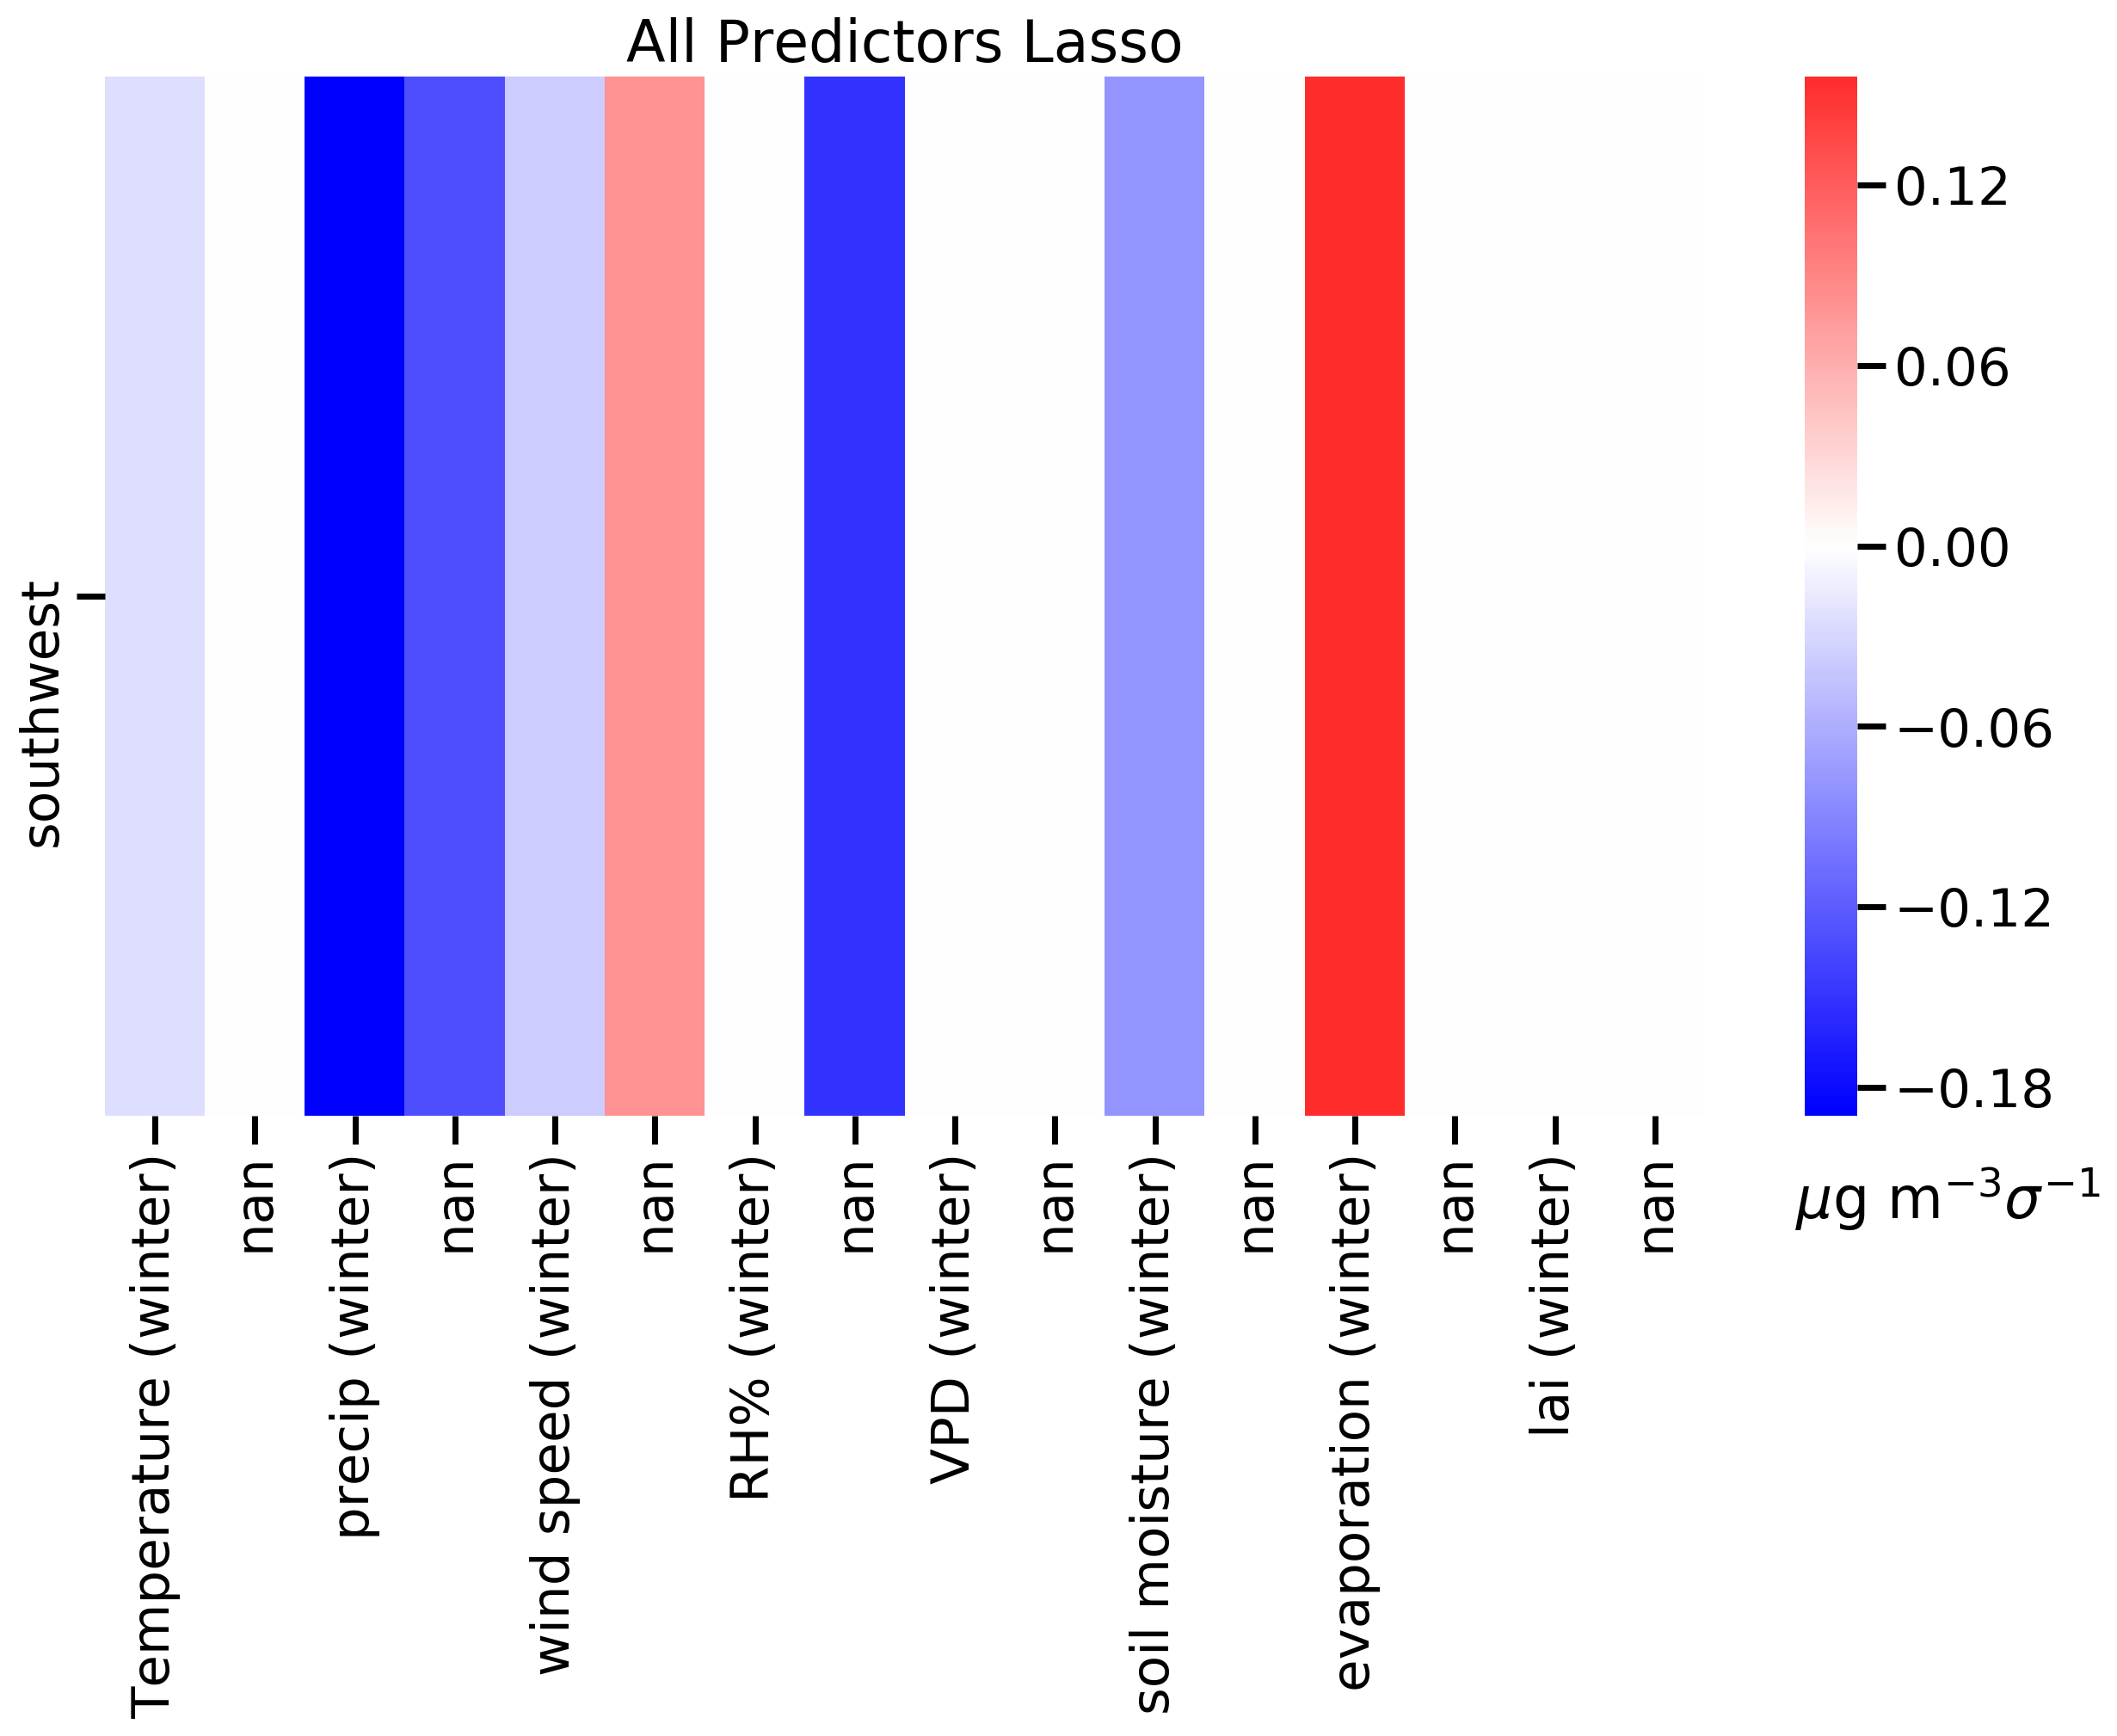

In [17]:
with sns.plotting_context("poster") :
    # TODO: Show r-squared on this plot 
    xticklabels = ndf.loc[lasso_all_coefs.columns.values, "nice_name"]
    
    f, ax = plt.subplots(figsize=(15, 8), dpi=200)
    ax1 = sns.heatmap(lasso_all_coefs, center=0, cmap="bwr", xticklabels=xticklabels)
    ax1.set(xlabel="", ylabel="", title="All Predictors Lasso")
    f.text(x=0.78, y=.05, s="$\mu$g m$^{-3}$$\sigma^{-1}$")
    plt.savefig(os.path.join(dataDir, "lasso_all_coefs_heat_matrix.png"), bbox_inches='tight')
    #plt.xticks(rotation=80)
    plt.show()

### Is it more meaningful to show this in terms of -max:max scale for each ecoregion so that local importance and sign of relationship is what is shown? 

- Here is how to do that in case that makes more sense in the end

``````python
# normalize an array so the values range exactly between 0 and 1
Xmax, Xmin = X.max(), X.min()
S = (X - Xmin)/(Xmax - Xmin)

``````

Create a dataframe that contains the r-squared values for various linear models

In [140]:
R2_df = pd.DataFrame(divisions[["OLS_r2","lasso_r2", "atmos_r2", "plant_r2"]])
R2_df.rename(columns={"OLS_r2":"OLS", 
                      "lasso_r2":"Lasso All",
                      "atmos_r2":"Lasso Temperature",
                      "plant_r2":"Lasso All without Temperature"}, 
                      inplace=True)
R2_df

OLS  Lasso All  Lasso Temperature  \
division                                                                    
Marine Regime Mountains            0.757939   0.688633           0.088600   
Mediterranean Regime Mountains     0.736131   0.595214           0.158276   
Temperate Steppe Regime Mountains  0.866786   0.817653           0.683131   

                                   Lasso All without Temperature  
division                                                          
Marine Regime Mountains                                 0.734131  
Mediterranean Regime Mountains                          0.566955  
Temperate Steppe Regime Mountains                       0.773915

As a sanity check only, the next figure should have highest performance for OLS, and more or less gradually decrease in skill. 

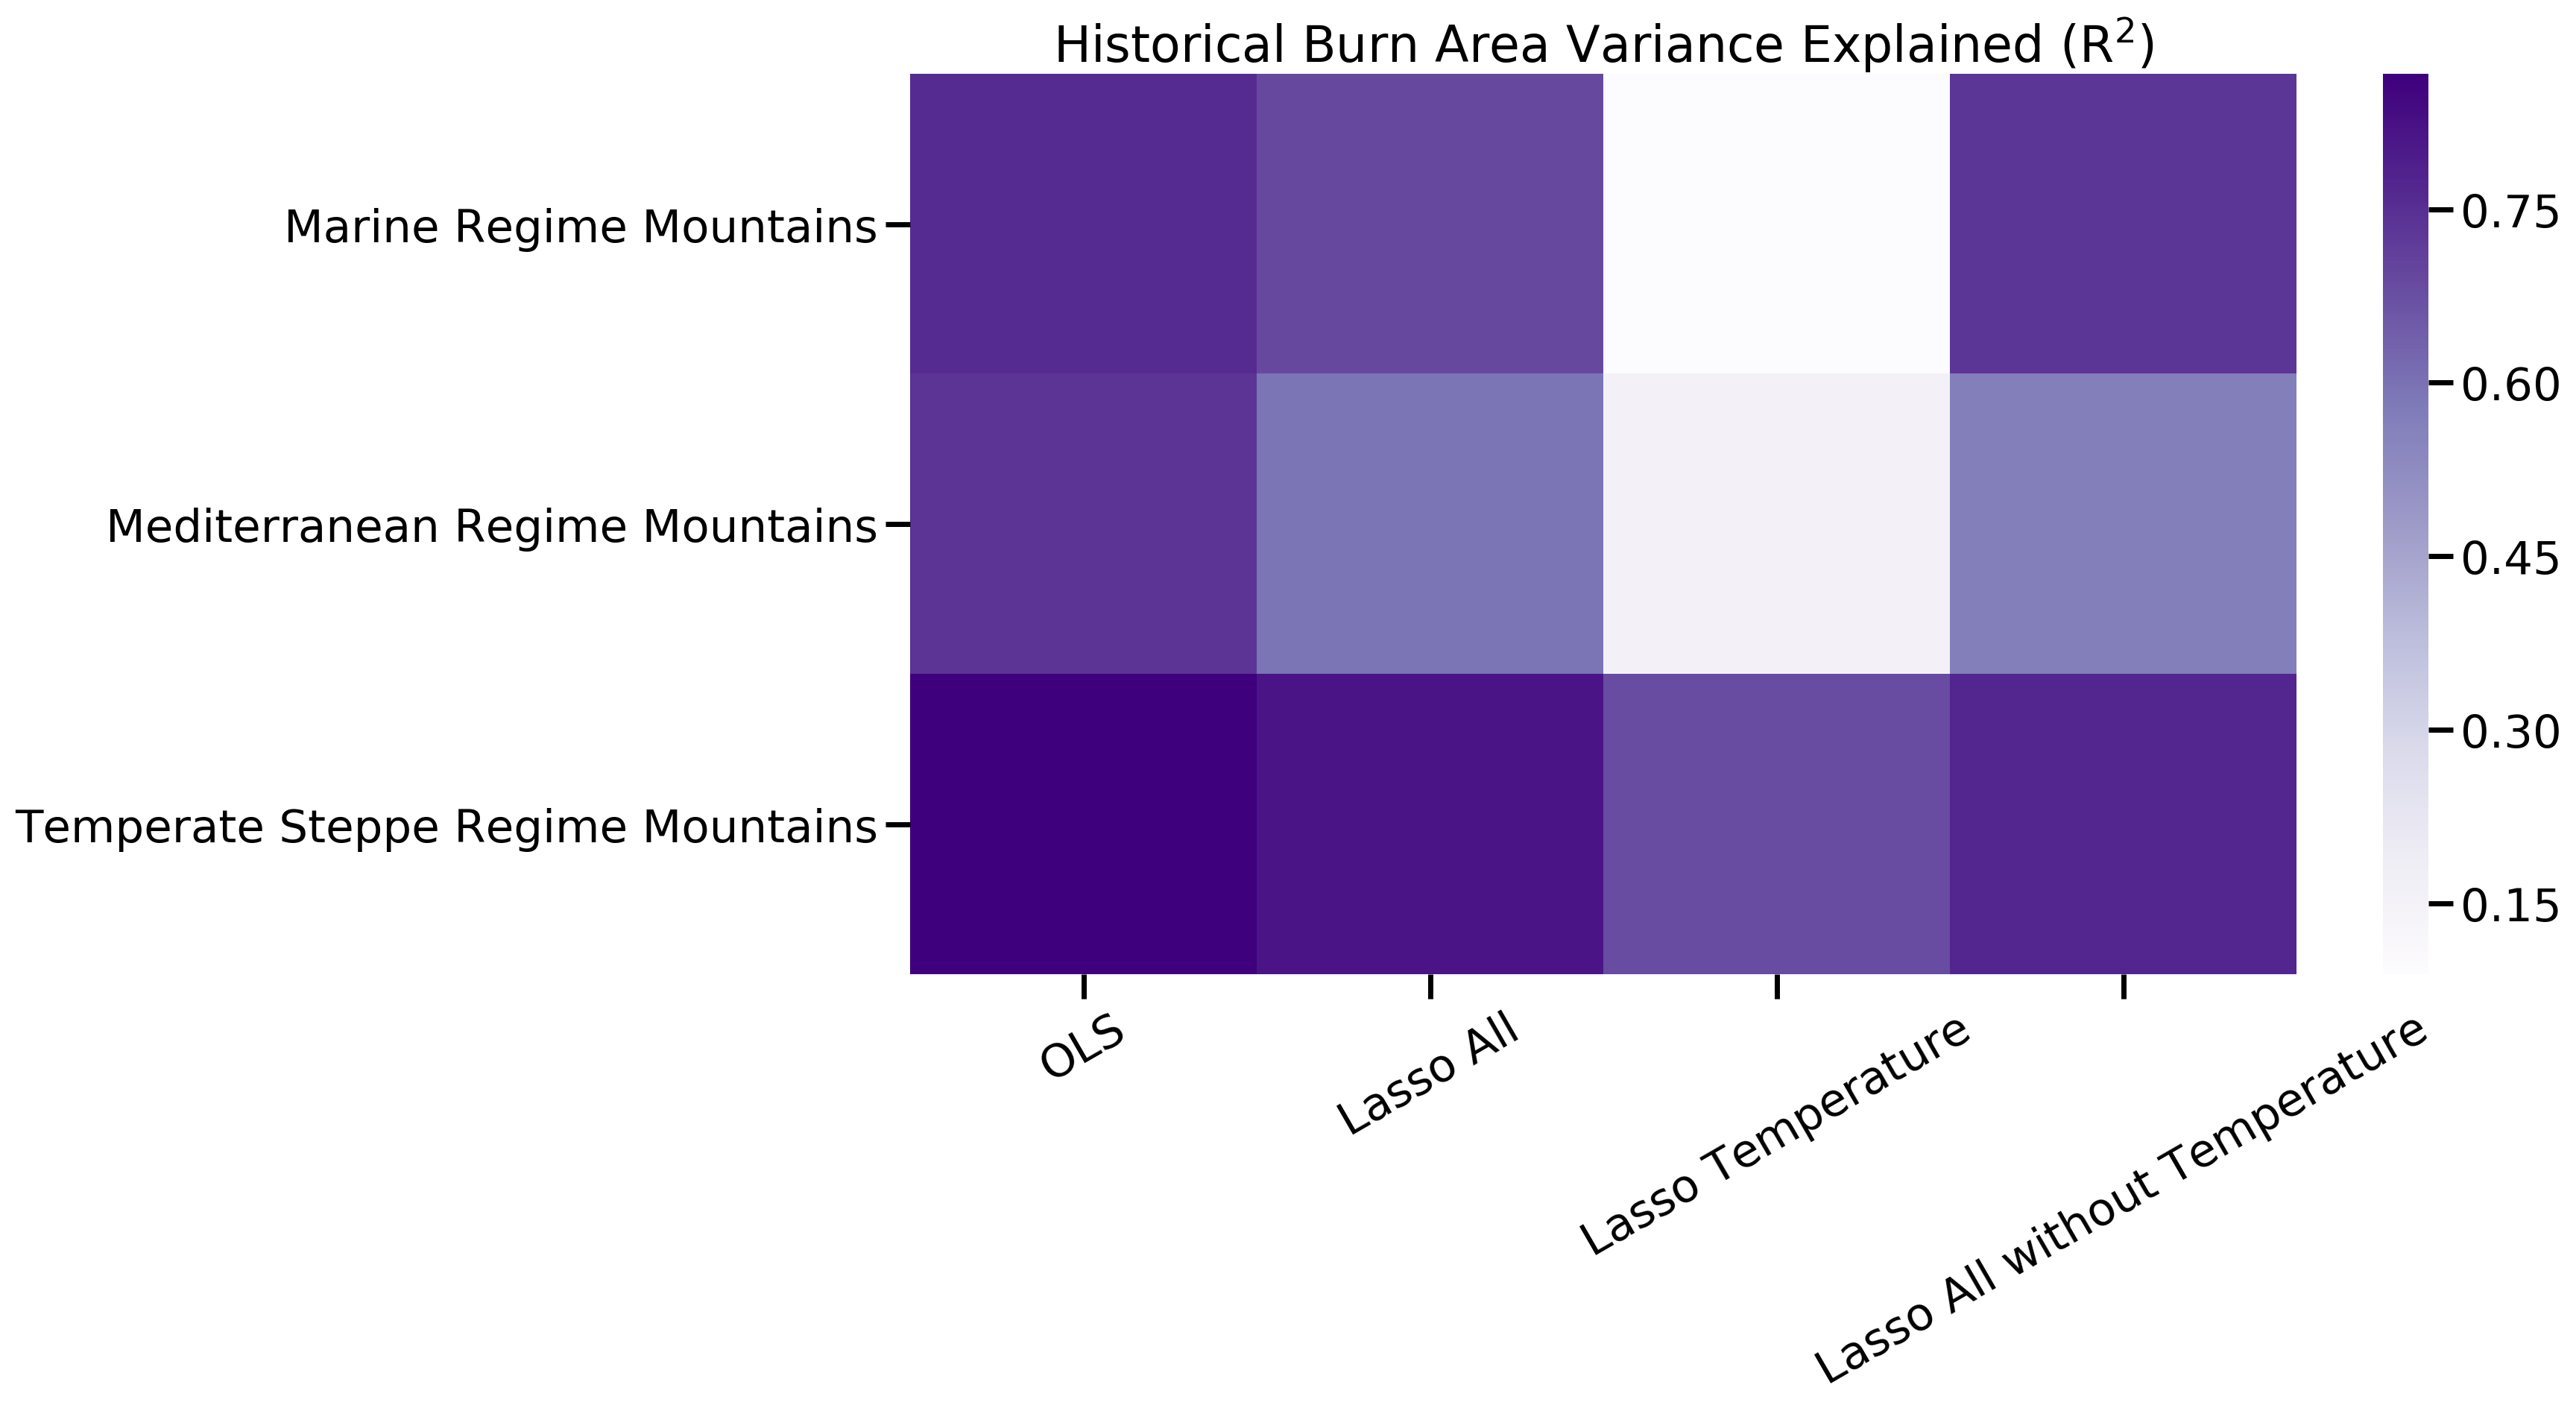

In [141]:
with sns.plotting_context("poster") :
    f, ax = plt.subplots(figsize=(15, 8), dpi=200)
    ax1 = sns.heatmap(R2_df, cmap="Purples")
    ax1.set(xlabel="", ylabel="", title="Historical Burn Area Variance Explained (R$^{2}$)")
    ax1.set_xticklabels(labels=R2_df.columns , rotation=30)
    #ax1.collections[0].colorbar.set_label("R$^{2}$")
    plt.savefig(os.path.join(dataDir,"models_variance_explained_heatmap.png"),  bbox_inches='tight')

# Show predictor importance and variance for lasso all
- NOTE: lasso_combined_coefs does not have columns in the same order as Z_dict of era-interim, so make sure that you account for that when reading data in function below. 

In [142]:
def get_cmip5_Z_dict(regression_name, rcp) :
    """
    Function for loading pickled CMIP5 dictionaries. Returns 
    dictionary associated with the specified file name. 
    """
    
    # Get the CMIP5 features expressed in terms of historical variance "Z_dict"
    # or their raw values averaged in a region ""
    f = regression_name + "_Z_cmip_" + rcp + '_dict.obj'
    print("Getting " + f)
    with open(os.path.join(dataDir, f), 'rb') as fp:
        Z_cmip_dict = pickle.load(fp)
    return Z_cmip_dict 

#### Setup a color dictionary for consistent colors for predictors, show some colobar options 

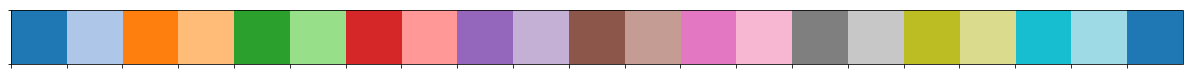

In [143]:
sns.palplot(sns.color_palette("tab20", n_colors=21))

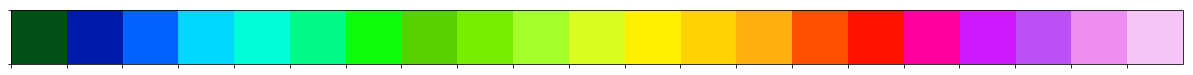

In [144]:
sns.palplot(sns.color_palette("gist_ncar", 21, 1))

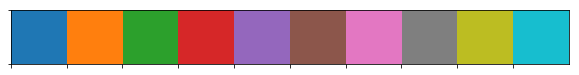

In [145]:
sns.palplot(sns.color_palette("tab10"))

### Make a custom legend and color scheme

In [146]:
# first, a color scheme, it adjusts when the number of unique colors changes.
# If there are more than 22 features then tab20 becomes a bad option. 
# if there are just over 20, then add colors from NCAR
print(lasso_all_coefs.shape)

n_column_coef = lasso_all_coefs.shape[1]
if n_column_coef > 22 :
    cols = sns.color_palette("gist_ncar", n_column_coef, 1)
else : 
    cols = sns.color_palette("tab20")
    
color_dict = {}
ii = 0 
for i in range(n_column_coef) :
    if i < 20 :
        color_dict[lasso_all_coefs.columns.values[i]] = cols[i]
    else :
        color_dict[lasso_all_coefs.columns.values[i]] = sns.color_palette("gist_ncar", 21, 1)[ii]
        ii += 1 

#color_dict

(3, 16)


#### Create a custom legend 
- For consistent colors for a given feature 
- Consistent shape for feature type (plant, atmos)

In [147]:
feature_legend = [] # empty list to be appended

# e.g.
# Green dot: Line2D([0], [0], marker='o', color='w', label='plant', markerfacecolor='g', markersize=15),
# Green square: Line2D([0], [0], marker='s', color='w', label='atmos', markerfacecolor='g', markersize=15),
for feature in color_dict.keys() : 

    fc = color_dict[feature]
    label_name = ndf.loc[feature, "nice_name"]

    # Set feature attributes to Line2D
    line_feature = Line2D([0], [0], marker="o", color='w', label=label_name, markerfacecolor=fc, markersize=15)
    # Store in list 
    feature_legend.append(line_feature)


In [148]:
def create_scatter_df(div, coef_df, div_Z_dict, y1=2070, y2=2099) :  
    """
    This creates a dataframe that makes for easy plotting and handling of differences
    in feature values from the training period 1984-2016 to years y1:y2. By the definition
    of how we standardize CMIP5 data for, the mean value for all CMIP model feature values
    for 1984-2016 the same as ERA-Interim, thus the difference is zero. The dataframe created
    
    Parameters
    ----------
        div : str, the division (ecoregion) for which a scatter_df will be created. 
        coef_df : pd.DataFrame, of lasso regression coeficients with shape =(n_division, n_features) 
        div_Z_dict : {}, containing different divisions dictionary of CMIP5 model Z (standardized)
                     output for estimating the change. 
        y1 : int, first year of the time period to average. 
        y2 : int, last year of the time period to average. 
        
    """
        
    # Get the division coeficients, only where non-zero, for this division. 
    df = coef_df.loc[div, coef_df.loc[div] != 0 ].copy()

    # Set up the DataFrame to hold information for scatterploting for div
    col_names = ["division", "feature", "feature_N", "feature_type", "coef", 
                 "CMIP5_mean", "CMIP5_std","CMIP5_min", "CMIP5_max"]
    
    df_scatter = pd.DataFrame(index=df.index, columns=col_names)
    df_scatter["division"]  = div
    df_scatter["feature_N"] = len(div_Z_dict.keys()) # models with all features for division 
    df_scatter["feature"]   = df_scatter.index.values.copy()
    df_scatter["coef"]      = df.values.copy()

    for model in div_Z_dict.keys() : 

        # Assign CMIP5 stats where they belong here. 
        Z_cmip = div_Z_dict[model]

        # We want the values for the last 30 years of 21st century
        # TODO: make time period a variable 
        future_mean_sigma = Z_cmip.loc[y1:y2, :].mean() # mean of columns, here variables 

        # Get the future sigma for the variables with non-zero coefs 
        # Add the new column for the data from THIS model 
        df_scatter[model] = future_mean_sigma[df_scatter.index]
            
    # Get the stats on the rows from the model sigma output. This gives the
    # mean of the changes calculated in the for loop above. 
    model_columns = list(div_Z_dict.keys())
    df_scatter.loc[:, "CMIP5_mean"] = df_scatter[model_columns].mean(axis=1).copy()
    df_scatter.loc[:, "CMIP5_std"] = df_scatter[model_columns].std(axis=1).copy()
    df_scatter.loc[:, "CMIP5_min"] = df_scatter[model_columns].min(axis=1).copy()
    df_scatter.loc[:, "CMIP5_max"] = df_scatter[model_columns].max(axis=1).copy()
    
    # Assign feature types
    # TODO: Pass these in
    
    for i in df_scatter["feature"] : 
        #print(i)
        s = pd.Series(i.split("_")[0]).isin(plant_vars).values
        #print(s)
        if  s : 
            df_scatter.loc[i, "feature_type"] = "Plant-Centric"
        else :
            df_scatter.loc[i, "feature_type"] = "Atmos-Centric"
            
    return df_scatter 

TODO: Remake this figure, capable of showing RCP 4.5 and 8.5 together

In [149]:
def plot_coef_vs_std(div, dataDir, regression_name, df, return_fig=False, rcp="8.5", color_dict='none', y1=2070, y2=2099) :  

    """
    Function for plotting a given divisions scatter_df (df), created by 
    the create_scatter_df() method. 
    
    Parameters
    ----------
        div : str, the name of the div being plotted, used for labelling only, as 
              df passed to function is already for a single division. 
        dataDir : Where the save the figure, if applicable. 
        reegression_name : str, the descriptive name of the type of regression associated
                           with how the data in df are stored. Example, plant- or -atmospheric
                           centric lasso regressions. 
        df : pd.DataFrame, this DataFrame was created by create_scatter_df() and 
             contains info about regression coef, how the coef variables change with CMIP5
             and the spread about those changes across available models. All for a specific
             rcp, division, regression. 
        return_fig : bool, when False a figure is created and saved. When True,
                     a figure object is return, and no figure is saved. This option
                     is desirable when a given div is being combined to a multipanel
                     plot with other divs using this function.
        rcp : str, used for labelling and figure savename only, as df is already associated
              with a specif rcp. 
    
    """
    # All sorts of string manipulation to make a decent
    # savename. 
    figure_savename = os.path.join(dataDir, "coef_scatter_plots" , regression_name + "_" + div.replace("/", " ") + "_coefs_vs_rcp"+rcp.replace(".","")+"_std.png")
    title_text = "RCP" +rcp +" CMIP5 $\mu_{"+str(y1)+"-"+str(y2)+"}$ - ERA-Interim $\mu_{1984-2016}$"    
    
    marker_dictionary = {"Plant-Centric":"o",
                         "Atmos-Centric":"s"
                        }
    
    if issubclass(type(color_dict), str) : 
        # No dictionar of colors passed, use defualt cmap
        pal = sns.color_palette("gist_ncar", df.shape[0], 1)
    else : 
        pal = color_dict
    
    ############################
    # Data ready, begin plotting 
    ############################
    if not return_fig :
        fig = plt.figure(dpi=250, figsize=(4, 4))
            
    ax = sns.scatterplot(x="coef", y="CMIP5_mean", hue="feature", data=df, 
                         #style="feature_type", 
                         #markers=marker_dictionary, 
                         s=70,
                         palette=pal, edgecolors="k", zorder=4)

    ax.axhline(y=0, color="k", linestyle="--", linewidth=0.8)
    ax.axvline(x=0, color="k", linestyle="--", linewidth=0.8)

    #ax.set(xlabel='Regression Coefficient [log$_{10}$(Burn Area) $\sigma^{-1}$]', 
    #       ylabel='$\Delta$  [ERA-Interim$\sigma$$_{1984-2016}$]')
    
    ax.set_xlabel('Coefficient [log$_{10}$(Burn Area) $\sigma^{-1}$]', fontsize=14)
    ax.set_ylabel('$\Delta$  [ERA-Interim$\sigma$$_{1984-2016}$]', fontsize=14)
    
    if not return_fig :
        ax.legend( bbox_to_anchor=(1,1.), title="", frameon=False)
        plt.title(label=title_text, fontsize=9)
        plt.suptitle(div)
    else :
        plt.title(label=div + " RCP" + rcp, fontsize=12)
        # remove spines for neat plots. 
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
    
    # Calculate the error (spread extent) bars for each variable
    error = np.zeros(shape=(2, len(df['CMIP5_min'])))
    lower_ext = df["CMIP5_mean"] - df['CMIP5_min']  # how far below 
    upper_ext = df['CMIP5_max'] - df["CMIP5_mean"]  # how far above 
    error[0][:] = np.array(lower_ext)
    error[1][:] = np.array(upper_ext)
    
    ax.errorbar(df["coef"], df["CMIP5_mean"], fmt=' ', 
                yerr=error, capsize=2, linewidth=0.8, 
                color="k", zorder=2)
    
    if not return_fig : 
        plt.savefig(figure_savename, bbox_inches='tight')
        plt.close()
    else :
        return ax
    

### plot_coef_vs_std() for regressions

In [150]:
# RCP8.5
lasso_all_Z_cmip85_dict   = get_cmip5_Z_dict(regression_name='lasso_all', rcp='85')
lasso_plant_Z_cmip85_dict = get_cmip5_Z_dict(regression_name='lasso_plant', rcp='85')
lasso_atmos_Z_cmip85_dict = get_cmip5_Z_dict(regression_name='lasso_atmos', rcp='85')

# RCP4.5
lasso_all_Z_cmip45_dict   = get_cmip5_Z_dict(regression_name='lasso_all', rcp='45')
lasso_plant_Z_cmip45_dict = get_cmip5_Z_dict(regression_name='lasso_plant', rcp='45')
lasso_atmos_Z_cmip45_dict = get_cmip5_Z_dict(regression_name='lasso_atmos', rcp='45')

Getting lasso_all_Z_cmip_85_dict.obj
Getting lasso_plant_Z_cmip_85_dict.obj
Getting lasso_atmos_Z_cmip_85_dict.obj
Getting lasso_all_Z_cmip_45_dict.obj
Getting lasso_plant_Z_cmip_45_dict.obj
Getting lasso_atmos_Z_cmip_45_dict.obj


Create the scatterplots from the individual experiments

In [151]:
# Dictionaries to store scatter dfs for divisions 
scatter_df_85_dict = {}
scatter_df_45_dict = {}

for div in lasso_all_coefs.index.values : 
    
    print(div)
    # RCP 8.5
    #df_1 = create_scatter_df(div, lasso_plant_coefs, lasso_plant_Z_cmip85_dict[div])
    #df_2 = create_scatter_df(div, lasso_atmos_coefs, lasso_atmos_Z_cmip85_dict[div])
    #df_scatter_85 = pd.concat([df_1, df_2], axis=0, sort=False)
    df_scatter_85 = create_scatter_df(div, lasso_all_coefs, lasso_all_Z_cmip85_dict[div])
    # Plot it 
    plot_coef_vs_std(div, dataDir, "lasso_all", df_scatter_85, return_fig=False, rcp="8.5", color_dict=color_dict)
    # Store the data associated with the plot 
    scatter_df_85_dict[div] = df_scatter_85
    
    # RCP 4.5
    #df_1 = create_scatter_df(div, lasso_plant_coefs, lasso_plant_Z_cmip45_dict[div])
    #df_2 = create_scatter_df(div, lasso_atmos_coefs, lasso_atmos_Z_cmip45_dict[div])
    #df_scatter_45 = pd.concat([df_1, df_2], axis=0, sort=False)
    df_scatter_45 = create_scatter_df(div, lasso_all_coefs, lasso_all_Z_cmip45_dict[div])
    # Plot it 
    plot_coef_vs_std(div,  dataDir, "lasso_all", df_scatter_45, False, "4.5", color_dict) 
    # Save plotted data 
    scatter_df_45_dict[div] = df_scatter_45    


Marine Regime Mountains
Mediterranean Regime Mountains
Temperate Steppe Regime Mountains


In [152]:
scatter_df_85_dict["Marine Regime Mountains"].head()

division                  feature  \
pr_spring                Marine Regime Mountains                pr_spring   
pr_summer                Marine Regime Mountains                pr_summer   
sfcWind_spring           Marine Regime Mountains           sfcWind_spring   
sfcWind_summer           Marine Regime Mountains           sfcWind_summer   
mrlsl.integrated_winter  Marine Regime Mountains  mrlsl.integrated_winter   

                         feature_N   feature_type      coef  CMIP5_mean  \
pr_spring                       15  Plant-Centric -0.328105    0.341469   
pr_summer                       15  Plant-Centric -0.619255   -0.610283   
sfcWind_spring                  15  Plant-Centric -0.085733   -0.635820   
sfcWind_summer                  15  Plant-Centric  0.237555   -0.403321   
mrlsl.integrated_winter         15  Plant-Centric -0.340835    0.583803   

                         CMIP5_std  CMIP5_min  CMIP5_max  ACCESS1-0  ...  \
pr_spring                 0.405678  -0.333358   0.954910  -0.333358  ...   
pr_summer                 0.584369  -1.542937   0.162573  -0.944894  ...   
sfcWind_spring            0.957241  -3.444720   0.543200  -0.222991  ...   
sfcWind_summer            0.852527  -2.197602   0.734409   0.414651  ...   
mrlsl.integrated_winter   0.842998  -0.926508   2.570870   2.570870  ...   

                         GFDL-ESM2G  GFDL-ESM2M  GISS-E2-H  GISS-E2-H-CC  \
pr_spring                  0.369848    0.067763   0.904920      0.503458   
pr_summer                 -0.510093   -0.613187  -0.158963      0.014675   
sfcWind_spring            -0.282019   -0.661936  -0.181426     -0.278581   
sfcWind_summer            -0.744537   -0.434714   0.122630     -0.430760   
mrlsl.integrated_winter    0.613624    0.102894   0.176552      1.046746   

                         GISS-E2-R  GISS-E2-R-CC  MIROC-ESM  MIROC-ESM-CHEM  \
pr_spring                 0.279869      0.762566  -0.002452       -0.097087   
pr_summer                -0.926538     -0.912979  -0.089520       -0.703693   
sfcWind_spring           -0.059141      0.543200  -2.135408       -3.444720   
sfcWind_summer           -0.321867     -0.732930  -0.535212        0.135809   
mrlsl.integrated_winter   0.810425      0.700253  -0.715443       -0.926508   

                           MIROC5    inmcm4  
pr_spring                0.805239  0.603694  
pr_summer               -0.121342 -1.531631  
sfcWind_spring          -0.396468 -0.501624  
sfcWind_summer          -2.197602  0.734409  
mrlsl.integrated_winter  0.784875  0.532307  

[5 rows x 24 columns]

## Coef vs. mean change scatterplot
### Show the scatterpots for the important mountinous regions on a common axis

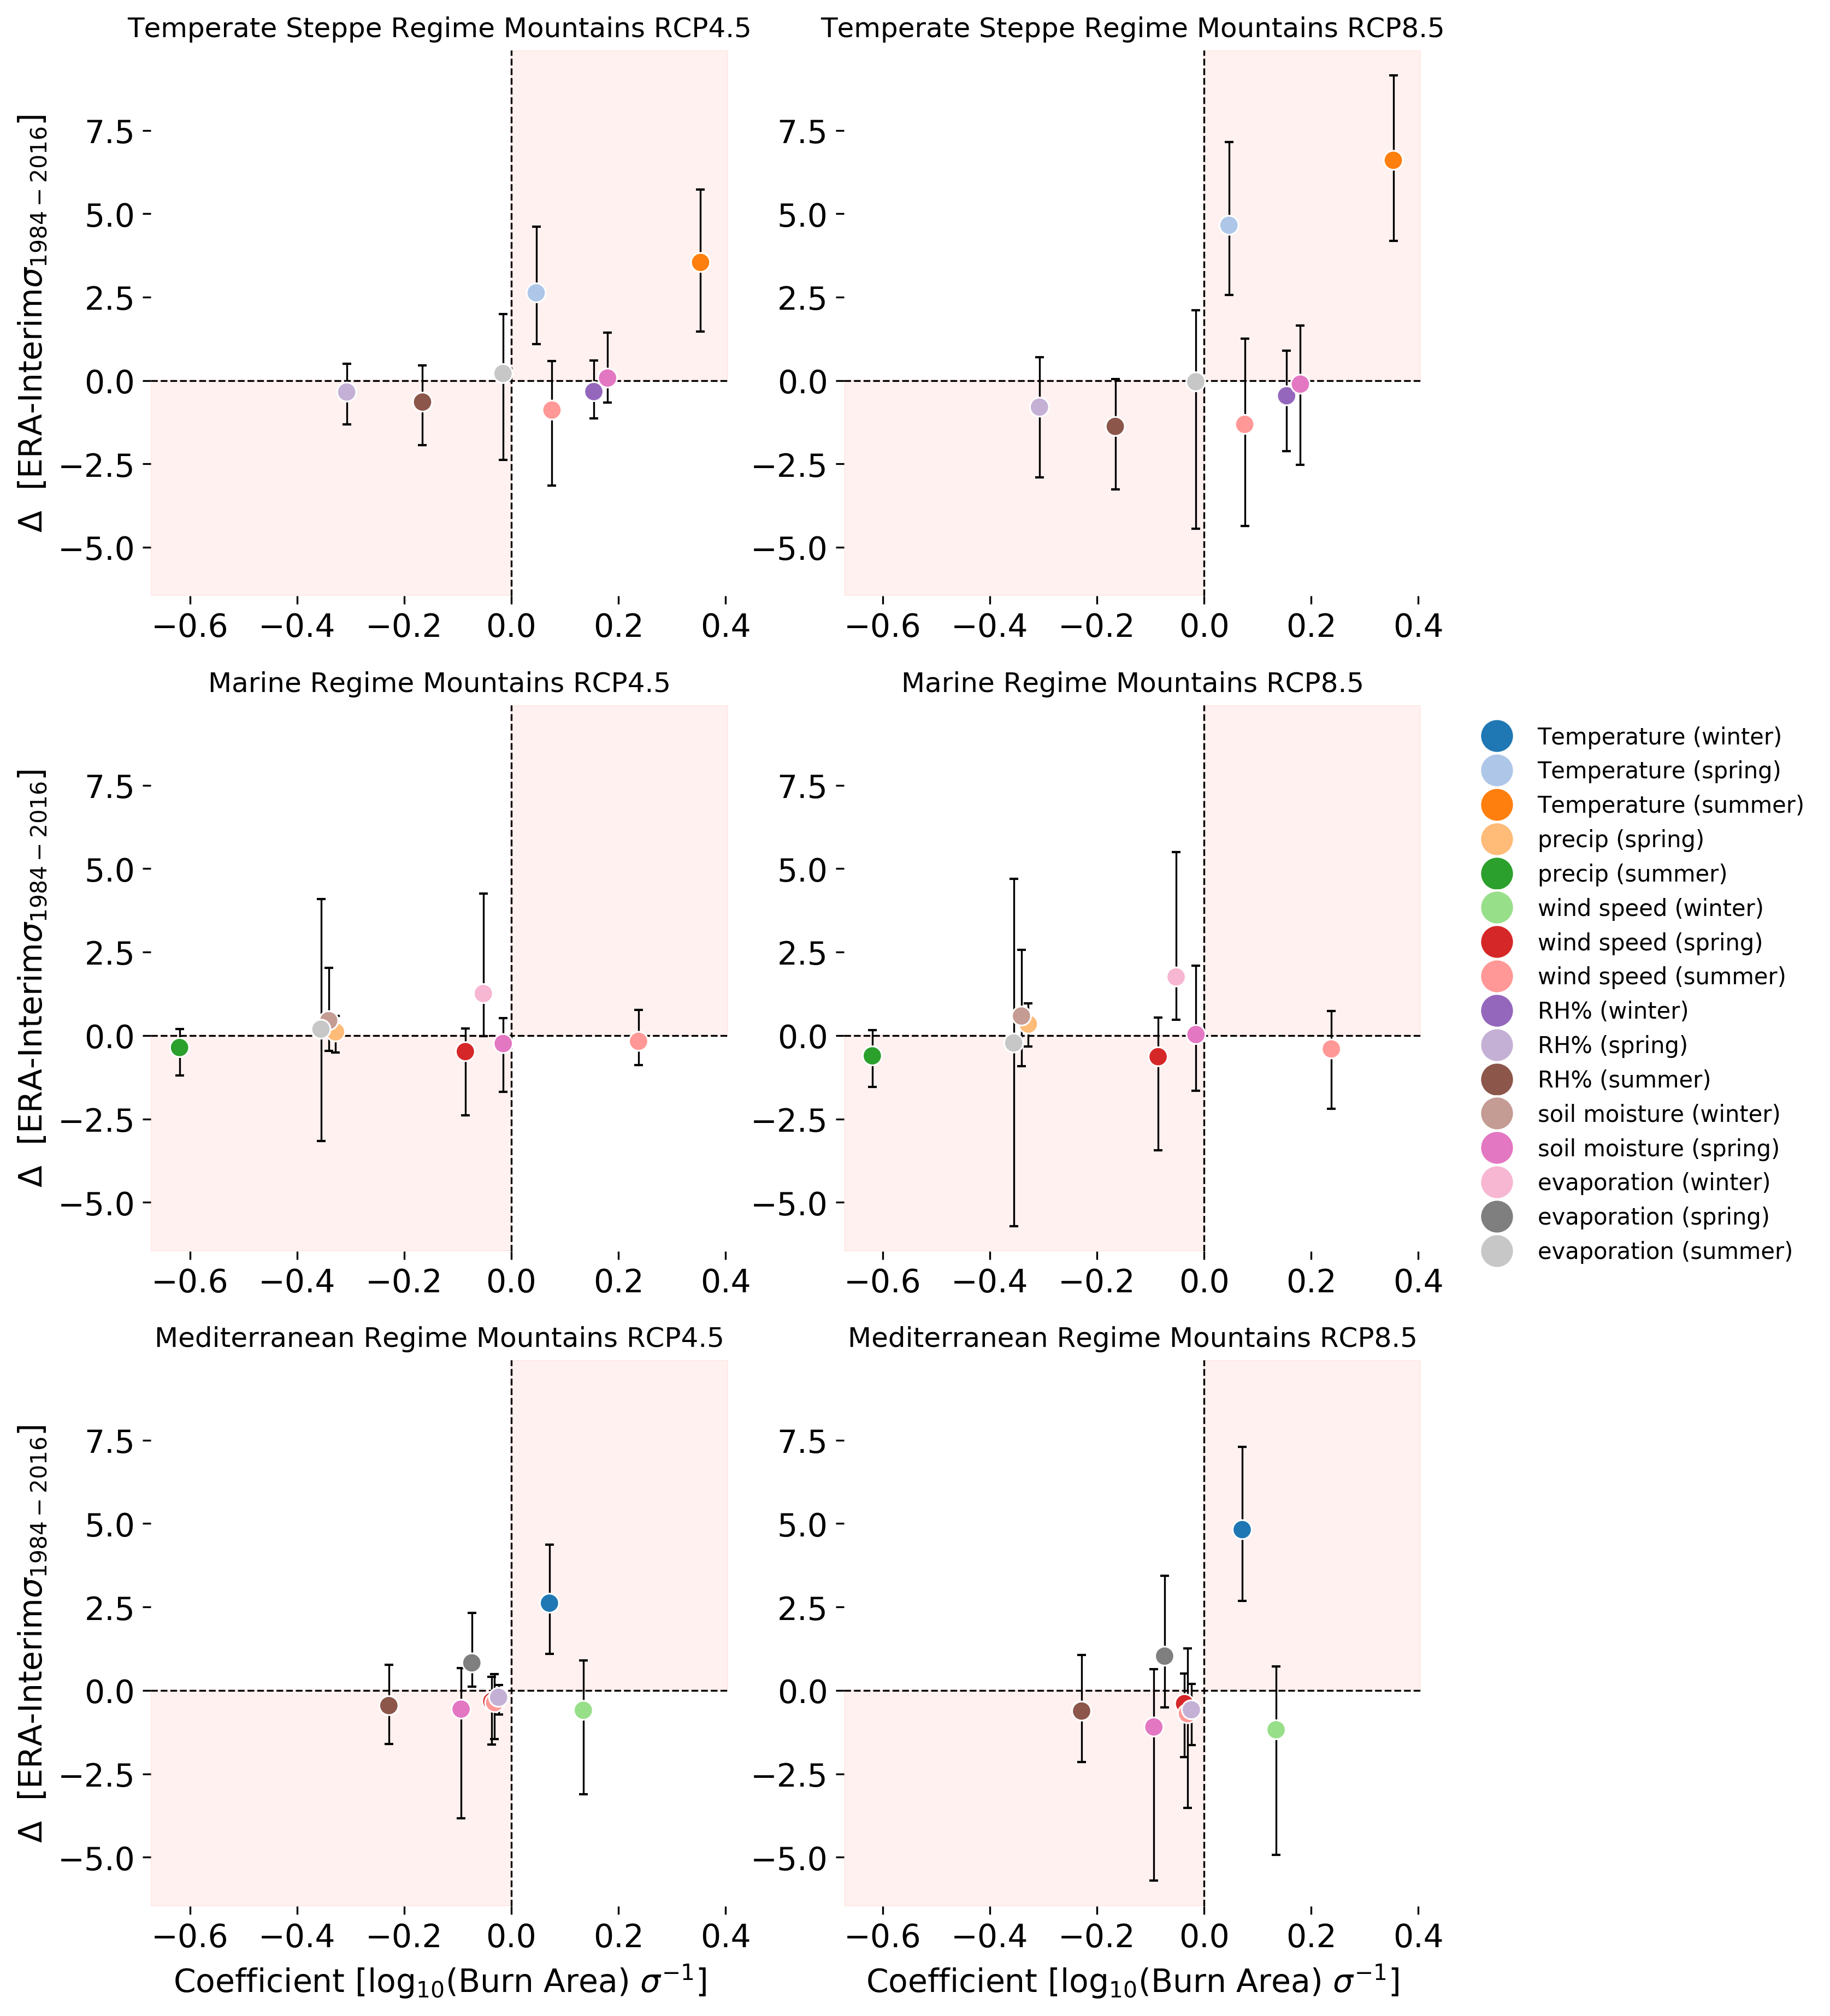

In [153]:
fig = plt.figure(dpi=300, figsize=(10,15))
plt.subplot(321)
ax1=plot_coef_vs_std("Temperate Steppe Regime Mountains", dataDir, "lasso_combined", 
                     scatter_df_45_dict["Temperate Steppe Regime Mountains"], 
                     return_fig=True, rcp="4.5", color_dict=color_dict)

plt.subplot(322, sharey=ax1, sharex=ax1)
ax2=plot_coef_vs_std("Temperate Steppe Regime Mountains", dataDir, "lasso_combined", 
                     scatter_df_85_dict["Temperate Steppe Regime Mountains"], 
                     return_fig=True, rcp="8.5", color_dict=color_dict)

plt.subplot(323, sharey=ax1, sharex=ax1)
ax3=plot_coef_vs_std("Marine Regime Mountains", dataDir, "lasso_combined", 
                     scatter_df_45_dict["Marine Regime Mountains"], 
                     return_fig=True, rcp="4.5", color_dict=color_dict)

plt.subplot(324, sharey=ax1, sharex=ax1)
ax4=plot_coef_vs_std("Marine Regime Mountains", dataDir, "lasso_combined", 
                     scatter_df_85_dict["Marine Regime Mountains"], 
                     return_fig=True, rcp="8.5", color_dict=color_dict)

plt.subplot(325, sharey=ax1, sharex=ax1)
ax5=plot_coef_vs_std("Mediterranean Regime Mountains", dataDir, "lasso_combined", 
                     scatter_df_45_dict["Mediterranean Regime Mountains"], 
                     return_fig=True, rcp="4.5", color_dict=color_dict)

plt.subplot(326, sharey=ax1, sharex=ax1)
ax6=plot_coef_vs_std("Mediterranean Regime Mountains", dataDir, "lasso_combined", 
                     scatter_df_85_dict["Mediterranean Regime Mountains"], 
                     return_fig=True, rcp="8.5", color_dict=color_dict)

# Do not show xaxis label for the top two rows
ax1.xaxis.label.set_visible(False)
ax2.xaxis.label.set_visible(False)
ax3.xaxis.label.set_visible(False)
ax4.xaxis.label.set_visible(False)

# Keep ylabel for only the left plots 1,3,5
ax2.yaxis.label.set_visible(False)
ax4.yaxis.label.set_visible(False)
ax6.yaxis.label.set_visible(False)

# Get/set require parameters for background shading
ymin, ymax = ax1.get_ylim()
xmin, xmax = ax1.get_xlim()
x0 = np.abs(xmin) / (np.abs(xmin)+np.abs(xmax))

tile_alpha = 0.5
tile_z = 0
down_color = "lavender"
up_color = "mistyrose"

# Set up looping through the panels 
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for ax in axes :
    ax.set_autoscale_on(False)
    #ax.axhspan(ymin=0, ymax=ymax, xmin=0, xmax=x0, color=down_color, zorder=tile_z, alpha=tile_alpha ) # Upper left
    #ax.axhspan(ymin=ymin, ymax=0, xmin=x0, xmax=1, color=down_color, zorder=tile_z, alpha=tile_alpha) # Lower right 
    ax.axhspan(ymin=ymin, ymax=0, xmin=0, xmax=x0, color=up_color, zorder=tile_z, alpha=tile_alpha) # Lower left 
    ax.axhspan(ymin=0, ymax=ymax, xmin=x0, xmax=1, color=up_color, zorder=tile_z, alpha=0.5) # upper right
    # Remove all individual legends 
    ax.legend_.remove()
    ax.tick_params(labelsize=14)
    
plt.subplots_adjust(hspace=0.2, wspace=0.2)

ax4.legend(handles=feature_legend)
# Handle the legend
leg = ax4.get_legend()
# [left, bottom, width, height]
leg.set_bbox_to_anchor((0.2, 1, 1.5, 0.0))
leg.set_label(divisions.division)
leg.set_frame_on(False)

plt.savefig(os.path.join(dataDir,"coef_scatter_plots", "lasso_all_rcp_scatter_compare.png"), format='png', bbox_inches="tight")
plt.show()

#### Code for how I learned how to make custom legends

````Python 
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Line'),
                   Line2D([0], [0], marker='o', color='w', label='plant',
                          markerfacecolor='g', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='atmos',
                          markerfacecolor='g', markersize=15),
                   Patch(facecolor='orange', edgecolor='r', label='Color Patch')]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=feature_legend, loc='center')

plt.show()

````

# Show these data together, using scatter, boxplots, & swarmplots

In [154]:
def make_delta_mean_df(df, rcp="8.5") :
    """
    
    WRITE A DOCSTRING FOR THIS COME ON! 
    
    Parameters
    ----------
        df : scatter df 
    """
    
    # Column attributes to describe the delta mean (sigma) values 
    value = []
    feature = []
    feature_type = [] 
    coef = []
    models = []
    feature_N = []
    division = []
    
    model_names = df.columns[9:].values
    variables = np.unique(df.index.values)

    #print(model_names)
    #print(variables)
    
    for var in variables :          # loop through features mean change 
        for model in model_names :  # for a given model

            value.append(df.loc[var, model])
            feature.append(var)
            feature_type.append(df.loc[var, "feature_type"])
            coef.append(df.loc[var, "coef"])
            division.append(df.loc[var, "division"])
            models.append(model)
            feature_N.append(df.loc[var, "feature_N"])
            
    coef = np.array(coef)
    sign = np.chararray((len(coef)), unicode=True)
    sign[:] = "- correlation"
    sign[coef > 0] = "+ correlation"
    

    return pd.DataFrame({"delta_mean":value, "feature":feature, 
                         "feature_type":feature_type, "coef":coef, "coef_sign":sign,
                         "division":division, "model":models, "feature_N":feature_N,
                         "rcp":rcp})

#### Create the nessisary dataframe structure 

In [155]:
l85 = [make_delta_mean_df(scatter_df_85_dict['Marine Regime Mountains'], "8.5"),
       make_delta_mean_df(scatter_df_85_dict['Temperate Steppe Regime Mountains'], "8.5"),
       make_delta_mean_df(scatter_df_85_dict['Mediterranean Regime Mountains'], "8.5")
      ]

l45 = [make_delta_mean_df(scatter_df_45_dict['Marine Regime Mountains'], "4.5"),
       make_delta_mean_df(scatter_df_45_dict['Temperate Steppe Regime Mountains'], "4.5"),
       make_delta_mean_df(scatter_df_45_dict['Mediterranean Regime Mountains'], "4.5")
      ]

# quickly look at the column names, they should all agree. 
for i in range(len(l85)) : 
    print(l85[i].columns.values)

df_85_delta_mean = pd.concat(l85) # axis=0, sort=False, ignore_index=True)
df_45_delta_mean = pd.concat(l45) # axis=0, sort=False, ignore_index=True)

['delta_mean' 'feature' 'feature_type' 'coef' 'coef_sign' 'division'
 'model' 'feature_N' 'rcp']
['delta_mean' 'feature' 'feature_type' 'coef' 'coef_sign' 'division'
 'model' 'feature_N' 'rcp']
['delta_mean' 'feature' 'feature_type' 'coef' 'coef_sign' 'division'
 'model' 'feature_N' 'rcp']


In [156]:
print(np.unique(df_85_delta_mean.rcp))
print(np.unique(df_45_delta_mean.rcp))

['8.5']
['4.5']


### Plotting both RCPs together

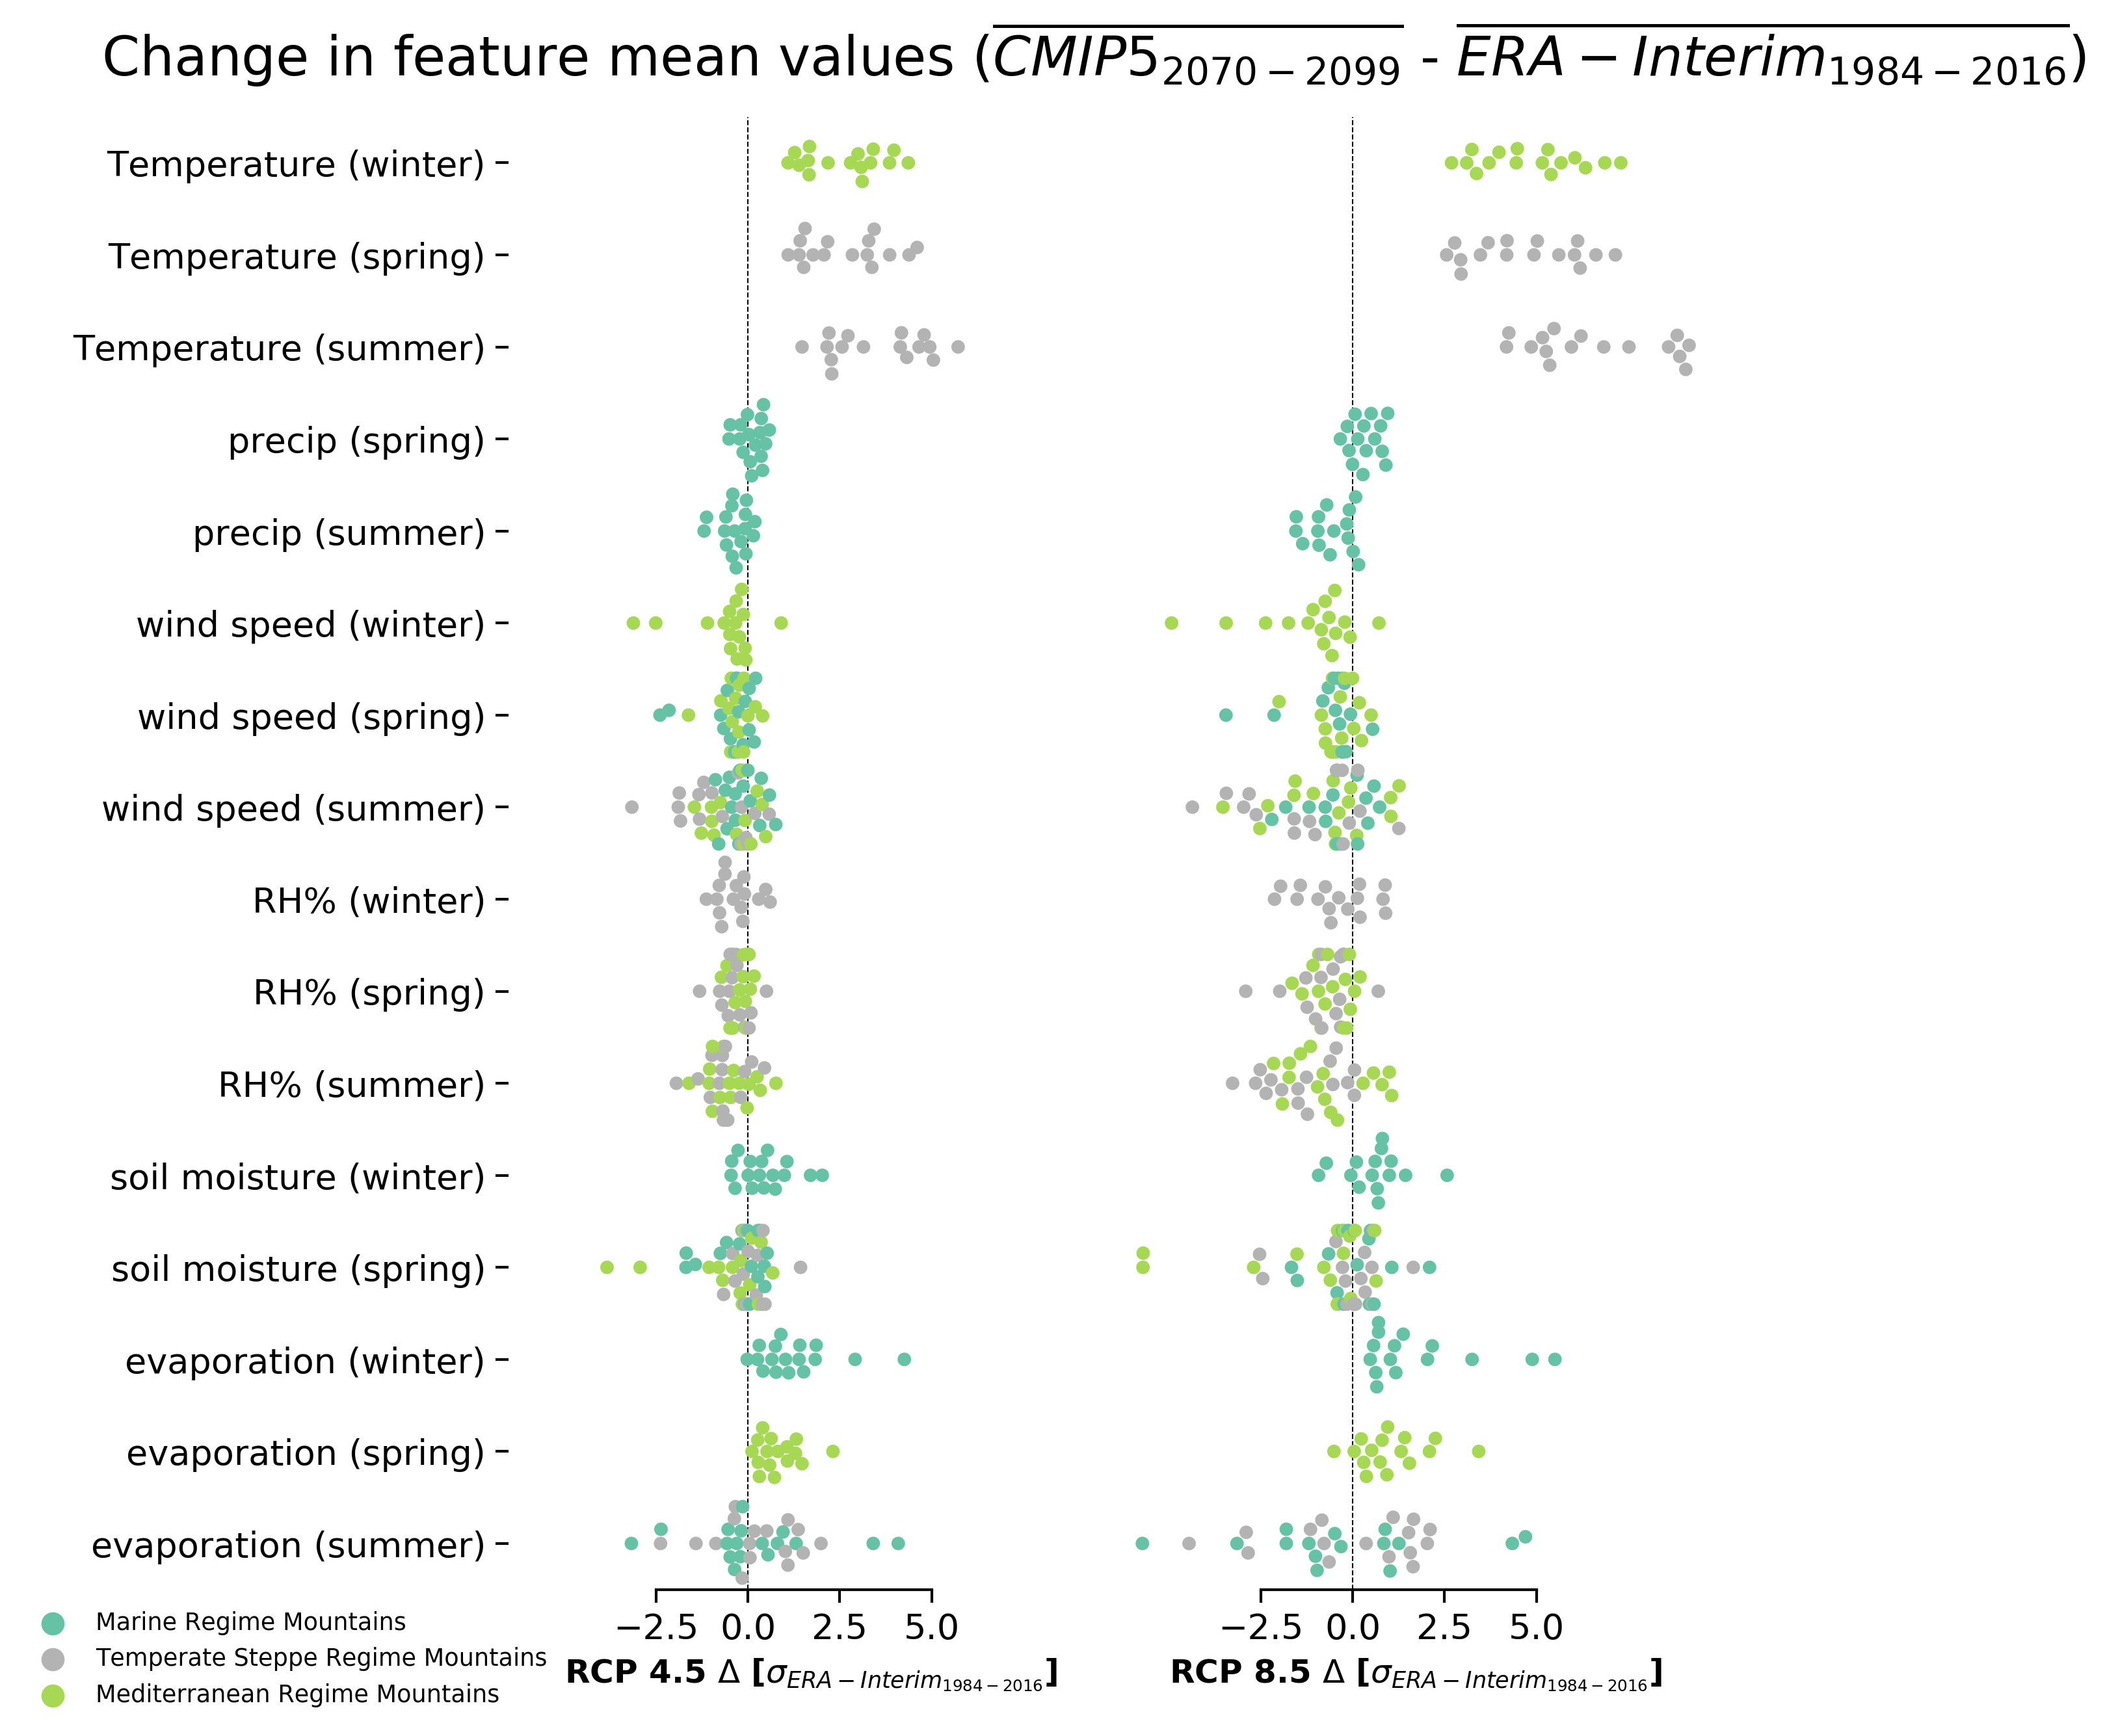

In [157]:
with sns.plotting_context("paper") :

    figure_name = "lasso_all_delta_means_swamplot.png"
    
    # Here we are sometimes plotting a subset of all the divisions, 
    # so make sure that no features that are not used by the selected
    # divisions are forced to be shown on the plot. 
    lasso_all_features = lasso_all_coefs.columns.values
    # Set the order of the features for the plot 

    features_mask = pd.Series(lasso_all_features).isin(np.unique(df_85_delta_mean.feature))
    plot_order = lasso_all_coefs.columns.values[features_mask]    
    lasso_all_features = lasso_all_features[features_mask]
    
    fig = plt.figure(dpi=300, figsize=(8,10))
    
    plt.subplot(1, 2, 1)
    yticklabels=ndf.loc[plot_order,"nice_name"]
    ax1 = sns.swarmplot(y="feature", x="delta_mean", 
                        hue="division", order=plot_order,
                        data=df_45_delta_mean, palette=div_color_dict)
    ax1.tick_params(labelsize=13)
    ax1.set_xlabel('RCP 4.5 $\Delta$ [$\sigma_{ERA-Interim_{1984-2016}}$]', fontsize=12, weight = 'bold')
    ax1.set(ylabel="")
    sns.despine(trim=True, left=True)
    
    plt.axvline(x=0, linestyle="--", color="k", linewidth=0.5)
    #plt.axhline(y=(last_plant_index + 0.5) , linestyle="--", color="k", linewidth=0.5)

    # Handle the legend
    leg = ax1.get_legend()
    # [left, bottom, width, height]
    leg.set_bbox_to_anchor((1.0, 0.45, 0.5, -0.5))
    leg.set_label(divisions.division)
    leg.set_title("")
    leg.set_frame_on(False)
    
    ################################################################
    # Second panel 
    plt.subplot(122, sharex=ax1, sharey=ax1)
    ax2 = sns.swarmplot(y="feature", x="delta_mean", 
                        hue="division", order=plot_order,
                        data=df_85_delta_mean, palette=div_color_dict)
    sns.despine(trim=True, left=True)
    ax2.tick_params(labelsize=13)
    plt.axvline(x=0, linestyle="--", color="k", linewidth=0.5)
    ax2.set_xlabel('RCP 8.5 $\Delta$ [$\sigma_{ERA-Interim_{1984-2016}}$]', fontsize=12, weight = 'bold')
    ax2.set(ylabel="")
    ax2.yaxis.set_visible(False)
    ax2.legend_.remove()
    
    ax1.set_yticklabels(yticklabels)   
    
    # Reduce the distance between the columns for subplots 
    plt.subplots_adjust(wspace=0.0)
    
    # Make labels bold 
    #plt.rcParams['axes.labelweight'] = 'bold'
    leg = ax1.get_legend()
    # [left, bottom, width, height]
    leg.set_bbox_to_anchor((-0.2, 0.5, 0.3, -0.5))
    leg.set_label(divisions.division)
    leg.set_title("")
    leg.set_frame_on(False)
    
    
    fig.suptitle("Change in feature mean values ($\overline{CMIP5_{2070-2099}}$ - $\overline{ERA-Interim_{1984-2016}}$)",
                y=0.93, fontsize=20)
    
    plt.savefig(os.path.join(dataDir, figure_name),  bbox_inches='tight')
    
    plt.show()

### Need a plot that shows the result of the mean change of CMIP5 variable times the coeficient. 
- but also all the individual model results to be transparent about the spread, use the mean values for ranking. 
- This will provide easy explanations of changes in projections that are soon. 

In [37]:
def transform_scatter_dict(df) : 
    """
    Transforms a scatter df and repeats columns by specific model 
    changes in cmip5 model values for different variables. Calculates
    'impact', coef x model_change for a given model, variable, etc. combo. 
    
    Parameters
    ----------
        df: pd.DataFrame, scatter_df, see create_scatter_df() method for
            detials. 
    reuturn
    -------
        pd.DataFrame, with model change information with associated 
        values previosuly independent columns in scatter_df, now 
        those are features in like rows. The goal is to get this
        in good shape to be plotted by seaborn.swarmplot()
    
    """
    
    # New columns. These must all exist in df.columns
    column_names = ["division", "feature", "feature_type", "coef", "model_name", "model_change"]

    k = [i for i,item in enumerate(df.columns.values) if "CMIP5_max" in item][0]
    model_names = df.columns.values[(k+1):]

    d = {} # Fill a dictionary with lists 
    for n in column_names : 
        d[n] = []

    #for div in df.division
    for model in model_names :
        #print(model)
        for i in df.index.values :

            d['model_name'].append( model )
            d['model_change'].append( df.loc[i, model] )
            for n in column_names[:-2] : 
                d[n].append(df.loc[i, n])

    # Estimate impact of each linear coef model change estimate by
    # multiplying the two 
    DF = pd.DataFrame(d)
    DF["impact"] = DF.coef * DF.model_change
                
    return DF

In [38]:
d_med = transform_scatter_dict(scatter_df_85_dict["Mediterranean Regime Mountains"].copy())
d_marine = transform_scatter_dict(scatter_df_85_dict["Marine Regime Mountains"].copy())
d_temperate = transform_scatter_dict(scatter_df_85_dict["Temperate Steppe Regime Mountains"].copy())

print(d_med.shape)
print(d_marine.shape)
print(d_temperate.shape)

df_impact_85 = pd.concat([d_med, d_marine, d_temperate])
print(df_impact_85.shape)

(128, 7)
(120, 7)
(128, 7)
(376, 7)


In [39]:
d_med = transform_scatter_dict(scatter_df_45_dict["Mediterranean Regime Mountains"].copy())
d_marine = transform_scatter_dict(scatter_df_45_dict["Marine Regime Mountains"].copy())
d_temperate = transform_scatter_dict(scatter_df_45_dict["Temperate Steppe Regime Mountains"].copy())

print(d_med.shape)
print(d_marine.shape)
print(d_temperate.shape)

df_impact_45 = pd.concat([d_med, d_marine, d_temperate])
print(df_impact_45.shape)

(128, 7)
(136, 7)
(128, 7)
(392, 7)


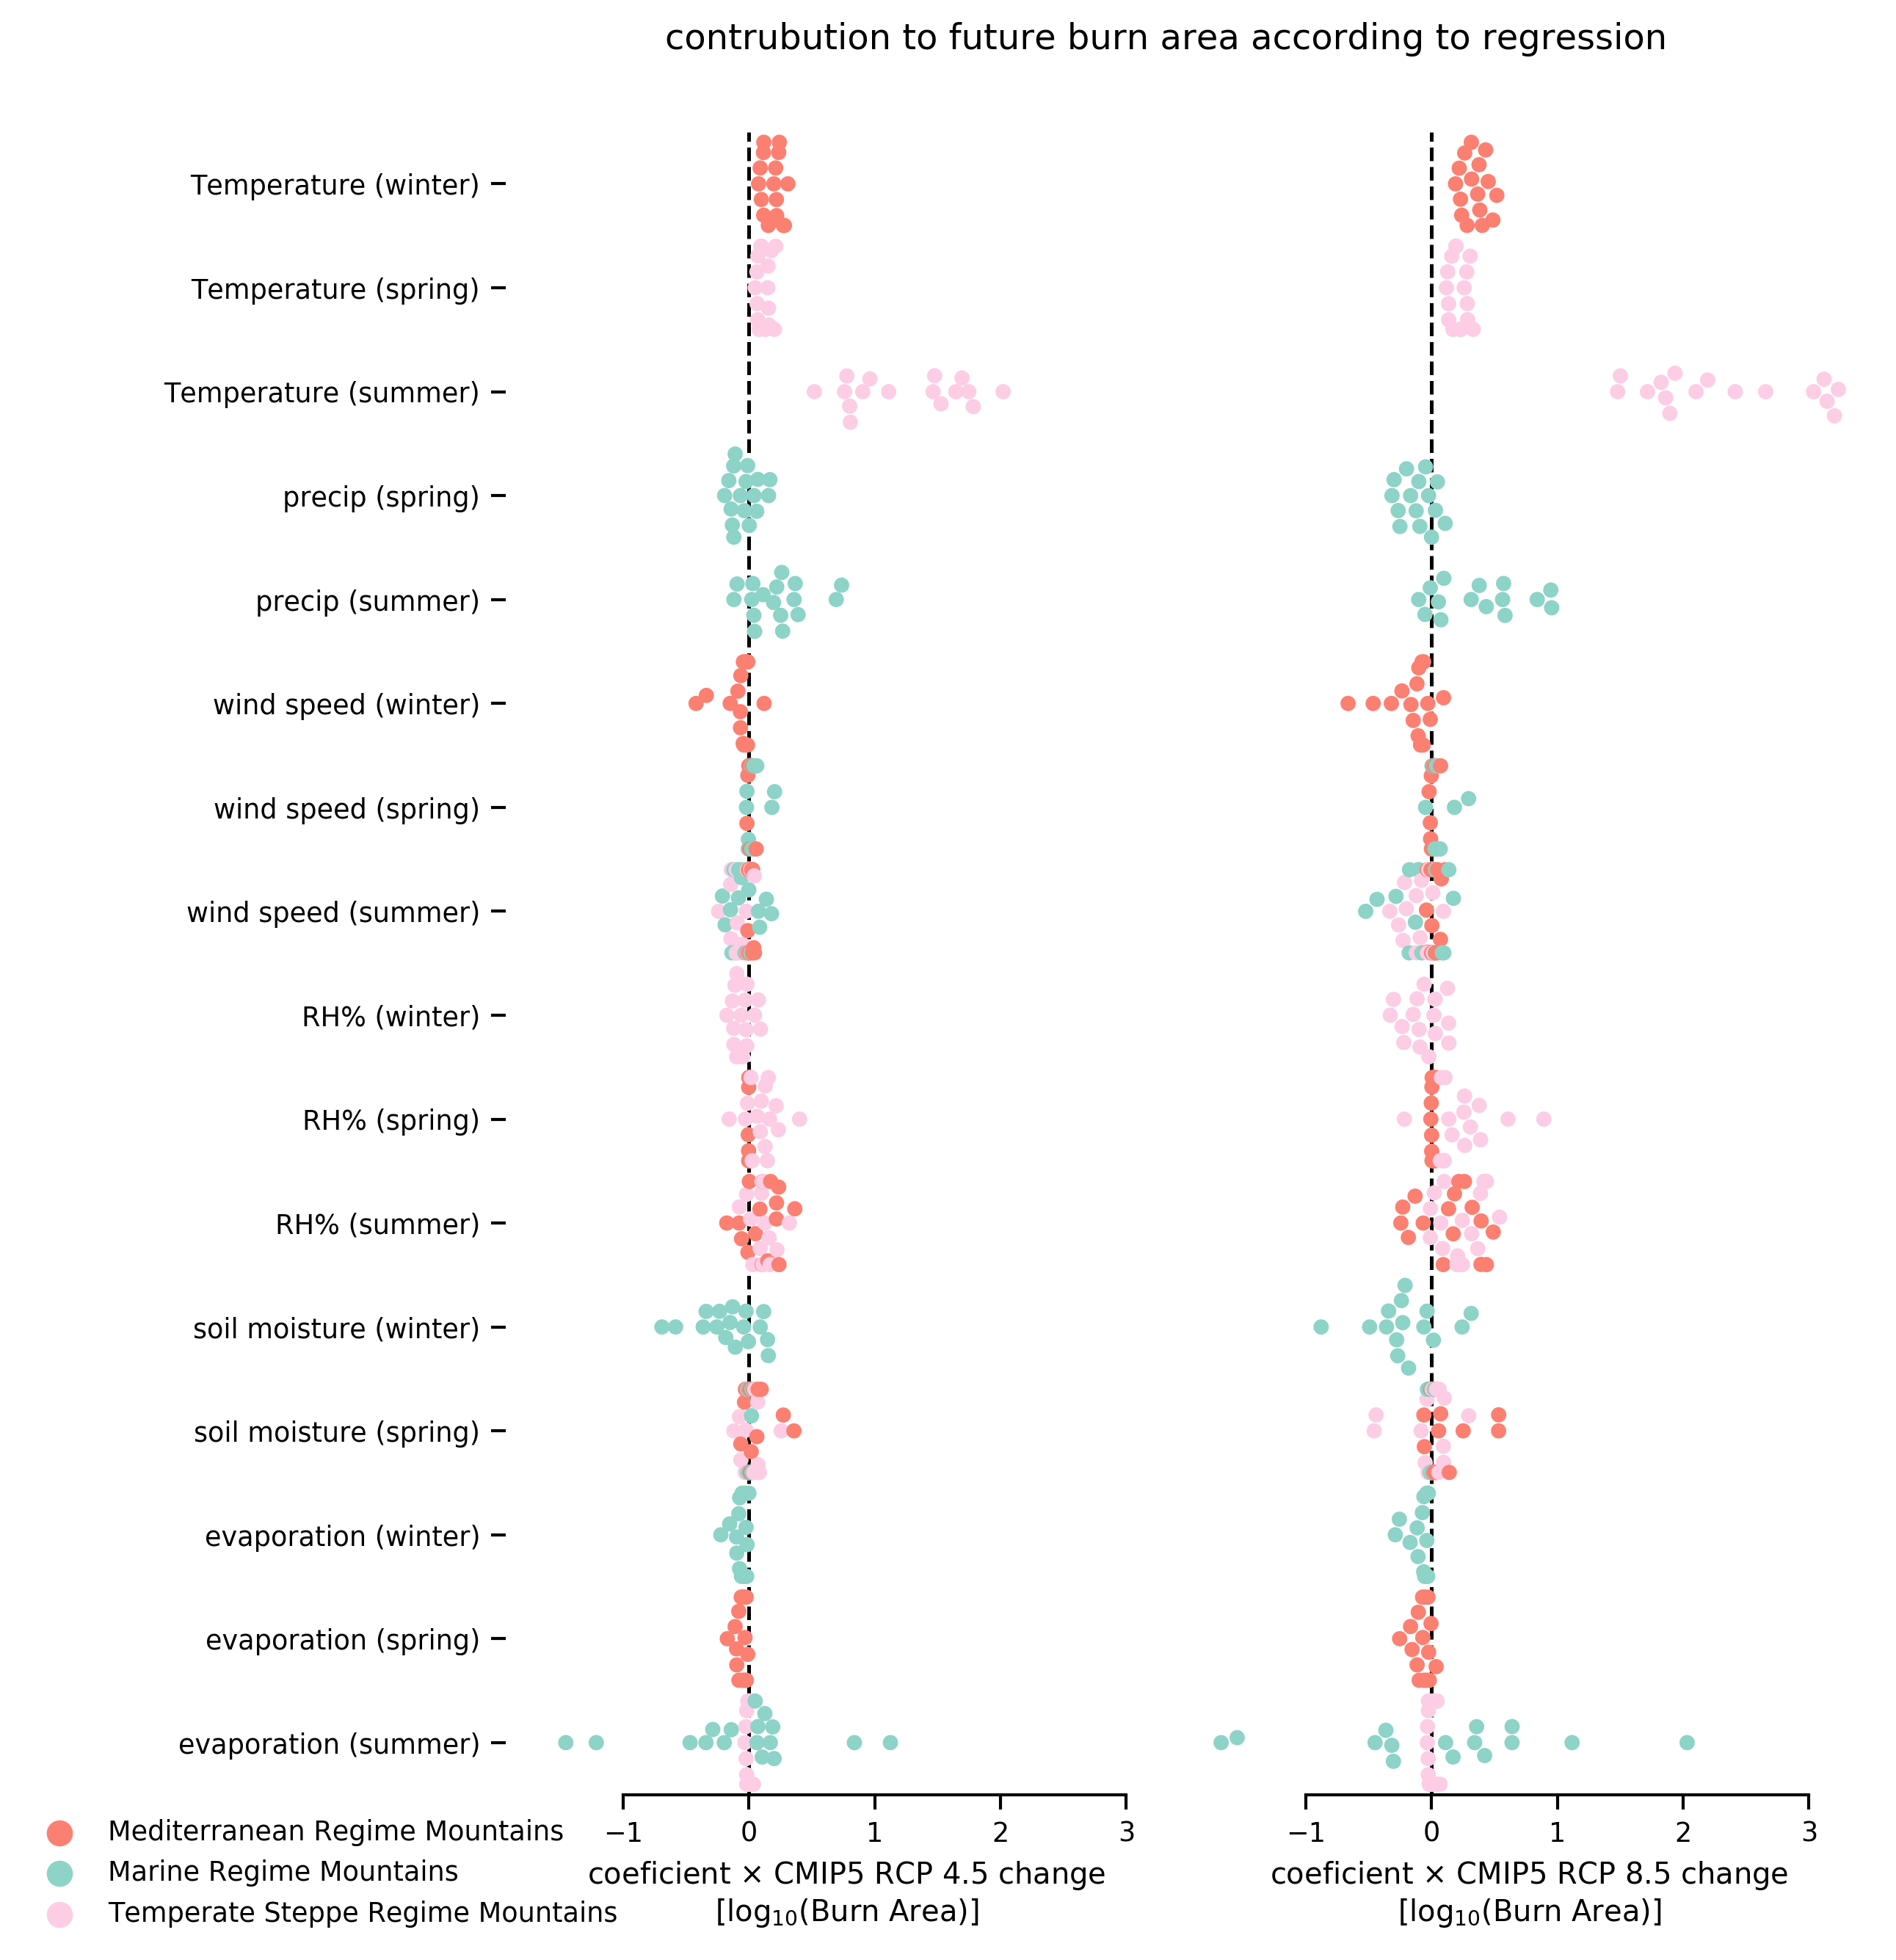

In [40]:
with sns.plotting_context("paper") :

    fig = plt.figure(dpi=300, figsize=(8,10))
    
    yticklabels=ndf.loc[plot_order,"nice_name"]

    plt.subplot(121)
    ax1 = sns.swarmplot(x="impact", y="feature", hue="division", order=plot_order,
                        palette=div_color_dict, data=df_impact_45)
    plt.xlabel("coeficient $\\times$ CMIP5 RCP 4.5 change\n[log$_{10}$(Burn Area)]")
    plt.ylabel("")
    #plt.xticks(rotation=90)
    plt.axvline(0, c="k", linestyle="--")
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    

    plt.subplot(122, sharex=ax1, sharey=ax1)
    ax2 = sns.swarmplot(x="impact", y="feature", hue="division", order=plot_order,
                        palette=div_color_dict, data=df_impact_85)
    sns.despine(trim=True, left=True)
    plt.xlabel("coeficient $\\times$ CMIP5 RCP 8.5 change\n[log$_{10}$(Burn Area)]")
    plt.ylabel("")
    
    ax2.yaxis.set_visible(False)
    ax2.legend_.remove()
    plt.axvline(x=0, linestyle="--", color="k")
    
    ## Figure out where to draw the line that separates plants from atmos
    #last_plant_index = np.where(lasso_combined_features == lasso_plant_coefs.columns[-1])[0][0]
    #plt.axhline(y=(last_plant_index + 0.5) , linestyle="--", color="k", linewidth=0.5)

    leg = ax1.get_legend()
    # [left, bottom, width, height]
    leg.set_bbox_to_anchor((-0.1, 0.5, 0.3, -0.5))
    leg.set_label(divisions.division)
    leg.set_title("")
    leg.set_frame_on(False)
    
    ax1.set_yticklabels(yticklabels)
    
    # Reduce the distance between the columns for subplots 
    plt.subplots_adjust(wspace=0.0)

    fig.suptitle("contrubution to future burn area according to regression", y=0.93)
    
    plt.savefig(os.path.join(dataDir, "lasso_all_rcp_85_change_times_coef.png"),  bbox_inches='tight')

    plt.show()

### Burn area visualization 

Here is how the two RCPs can be displayed together! This will be done by adding RCP as an attribute and changing the "col" parameter to "rcp" column of the df_delta_mean.

Possible way to make ranked boxplot needed. 
https://stackoverflow.com/questions/39214484/how-to-rank-plot-in-seaborn-boxplot

#### Handy functions for burn area plots 

In [41]:
dataDir

'../Data/Fire_Analysis/CARTHAGE_MUST_BURN_50_transofromation_log10'

In [42]:
def get_BA_dict(regression_name, rcp) :
    """
    Function for loading pickled burn area dictionaries for different
    regressions and scenarios. 
    """
    
    # Get the CMIP5 features expressed in terms of historical variance "Z_dict"
    # or their raw values averaged in a region ""
    f = regression_name + "_BA_rcp" + rcp + '.obj'
    #print("Getting " + f)
    with open(os.path.join(dataDir, f), 'rb') as fp:
        d = pickle.load(fp)
    return d 

def ensemble_stats(BA) :
    """Takes stats across models for each row (year)"""
    return BA.mean(axis=1), BA.min(axis=1), BA.max(axis=1)

def make_arrow_points(y1, y2) :
    """
    y1 : series one to be averaged
    y2 : series two to be average
    
    Returns coordinates to draw arrows illistrating the distance
    betwen the mean of y1 y2 series. 
    """
    
    y1 = np.mean(y1)
    y2 = np.mean(y2)
    
    # TODO: Add functionality to average over specified years 
    delta = np.abs(y1 - y2)
    ymin = np.min([y1 , y2])
    ymax = np.max([y1 , y2])
    
    return delta, ymin, ymax

def get_historic_burn_area(div) :
    """Get historic burn area for a division"""
    with open(os.path.join(dataDir, "div_log10_burn_area_dict.obj"), 'rb') as fp:
        div_log10_burn_area = pickle.load(fp)
    return div_log10_burn_area[div]

In [67]:
# https://stackoverflow.com/questions/31671999/python-different-size-subplots-in-matplotlib?rq=1
def burn_area_projections(div, div_BA_atmos_45, div_BA_atmos_85, div_BA_plant_45, div_BA_plant_85, 
                          name_1="Temperature only", name_2="All variables") :

    ############################################################
    # Get data needed for plot 
    mtbs_BA = get_historic_burn_area(div)
        
    # Calculate the ensemble means! 
    BA_atmos_means_45, _, _ = ensemble_stats(div_BA_atmos_45)
    BA_atmos_means_85, _, _ = ensemble_stats(div_BA_atmos_85)
    BA_plant_means_45, _, _ = ensemble_stats(div_BA_plant_45)
    BA_plant_means_85, _, _ = ensemble_stats(div_BA_plant_85)
    
    # Label names
    # atmos = temperature only
    # plant = all variables    
    
    fig=plt.figure(figsize=(10,5), dpi=300)

    gs=GridSpec(2,3) # 2 rows, 3 columns

    #############################################################
    ax1=fig.add_subplot(gs[0,0:3]) # Time series

    # Plot mtbs_time series 
    #mtbs_years = np.arange(1984, 2017)
    #plt.plot(mtbs_years, mtbs_BA, color="C0")
    
    # Plot atmos
    plt.plot(BA_atmos_means_45, color="C1", linestyle="-", label=name_1)
    plt.plot(BA_atmos_means_85, color="C1", linestyle="--")
    # Plot plant
    plt.plot(BA_plant_means_45, color="green", linestyle="-", label=name_2)
    plt.plot(BA_plant_means_85, color="green", linestyle="--")

    # Style components 
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    plt.ylabel("log$_{10}$(Burn Area [acres])")
    plt.title( div)
    
    legend_elements = [Line2D([0], [0], color='k', lw=1, linestyle="--", label='RCP 8.5'),
                       Line2D([0], [0], color='k', lw=1, linestyle="-", label='RCP 4.5'),
                       Line2D([0], [0], marker='s', color='w', label=name_2, markerfacecolor='g', markersize=15),
                       Line2D([0], [0], marker='s', color='w', label=name_1, markerfacecolor='C1', markersize=15),
                       Line2D([0], [0], marker='s', color='w', label='Observed', markerfacecolor='C0', markersize=15)]

    # Create the figure
    ax1.legend(handles=legend_elements, loc='upper left', frameon=False, prop={'size': 9})
    

    #############################################################
    ax3=fig.add_subplot(gs[1,0]) # Second row, span all columns
    plt.xlabel("1984-2016")

    # Get Models attempt at historical prediction
    x1 = div_BA_atmos_45.loc[1984:2016, :].values.ravel()
    x2 = div_BA_atmos_85.loc[1984:2016, :].values.ravel()
    x3 = div_BA_plant_45.loc[1984:2016, :].values.ravel()
    x4 = div_BA_plant_85.loc[1984:2016, :].values.ravel()
    
    boxData = [mtbs_BA, x1, x2, x3, x4]
    labels  = ["MTBS", "4.5", "8.5", "4.5", "8.5"]
    colors  = ["C0","C1", "C1", "green", "green"]
    
    box = plt.boxplot(boxData, labels=labels,
                      medianprops = dict(linestyle='-', linewidth=1., color='k'),
                      notch=True, patch_artist=True)
    # Paint the boxes 
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.ylabel("log$_{10}$(Burn Area [acres])")

    ax3.spines['right'].set_visible(False)    
    ax3.spines['left'].set_visible(False)    
    ax3.spines['top'].set_visible(False)    
    ax3.spines['bottom'].set_visible(False)    

    #############################################################
    ax4=fig.add_subplot(gs[1,1], sharey=ax3)
    plt.xlabel("2040-2060")

    x1 = div_BA_atmos_45.loc[2040:2060, :].values.ravel()
    x2 = div_BA_atmos_85.loc[2040:2060, :].values.ravel()
    x3 = div_BA_plant_45.loc[2040:2060, :].values.ravel()
    x4 = div_BA_plant_85.loc[2040:2060, :].values.ravel()

    boxData = [x1, x2, x3, x4]

    colors = ["C1", "C1", "green", "green"]
    labels = ["4.5", "8.5", "4.5", "8.5"]
    box = plt.boxplot(boxData, labels=labels,
                      medianprops = dict(linestyle='-', linewidth=1., color='k'),
                      notch=True, patch_artist=True)
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    ax4.spines['right'].set_visible(False)    
    ax4.spines['left'].set_visible(False)    
    ax4.spines['top'].set_visible(False)    
    ax4.spines['bottom'].set_visible(False)    
    ax4.axes.get_yaxis().set_visible(False)

    #############################################################
    ax5=fig.add_subplot(gs[1,2], sharey=ax4)
    plt.xlabel("2080-2100")

    x1 = div_BA_atmos_45.loc[2080:2100, :].values.ravel()
    x2 = div_BA_atmos_85.loc[2080:2100, :].values.ravel()
    x3 = div_BA_plant_45.loc[2080:2100, :].values.ravel()
    x4 = div_BA_plant_85.loc[2080:2100, :].values.ravel()

    boxData = [x1, x2, x3, x4]

    colors = ["C1", "C1", "green", "green"]
    labels = ["4.5", "8.5", "4.5", "8.5"]
    box = plt.boxplot(boxData, labels=labels,
                      medianprops = dict(linestyle='-', linewidth=1., color='k'),
                      notch=True, patch_artist=True)
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    ax5.spines['right'].set_visible(False)    
    ax5.spines['left'].set_visible(False)    
    ax5.spines['top'].set_visible(False)    
    ax5.spines['bottom'].set_visible(False)    
    ax5.axes.get_yaxis().set_visible(False)

    #plt.subplots_adjust(wspace=0.6) # reduce spaces between panes
    fig.tight_layout()

    f = os.path.join(dataDir, div.replace("/"," ") + '_burn_area_projections.png')
    fig.savefig(f)
    plt.close()
    
    return fig, f 


### Get burn area data
- load the dictionary for all regression types and RCPs (4 total)
- subset to division of interest
- calculate esemble means

In [44]:
# Get burn area dictionary (keys are divisions)
lasso_all_BA_45 = get_BA_dict("lasso_all", "45")
lasso_all_BA_85 = get_BA_dict("lasso_all", "85")
lasso_temperature_BA_45 = get_BA_dict("lasso_atmos", "45")
lasso_temperature_BA_85 = get_BA_dict("lasso_atmos", "85")
#lasso_plant_BA_45 = get_BA_dict("lasso_plant", "45")
#lasso_plant_BA_85 = get_BA_dict("lasso_plant", "85")

In [72]:
# Figure to show spread

In [88]:
div = "Temperate Steppe Regime Mountains"
mtbs_BA = get_historic_burn_area(div)
mtbs_years = np.arange(1984, 2017)
T_BA_45 = lasso_temperature_BA_45[div] 
T_BA_85 = lasso_temperature_BA_85[div] 
all_BA_45 = lasso_all_BA_45[div] 
all_BA_85 = lasso_all_BA_85[div]


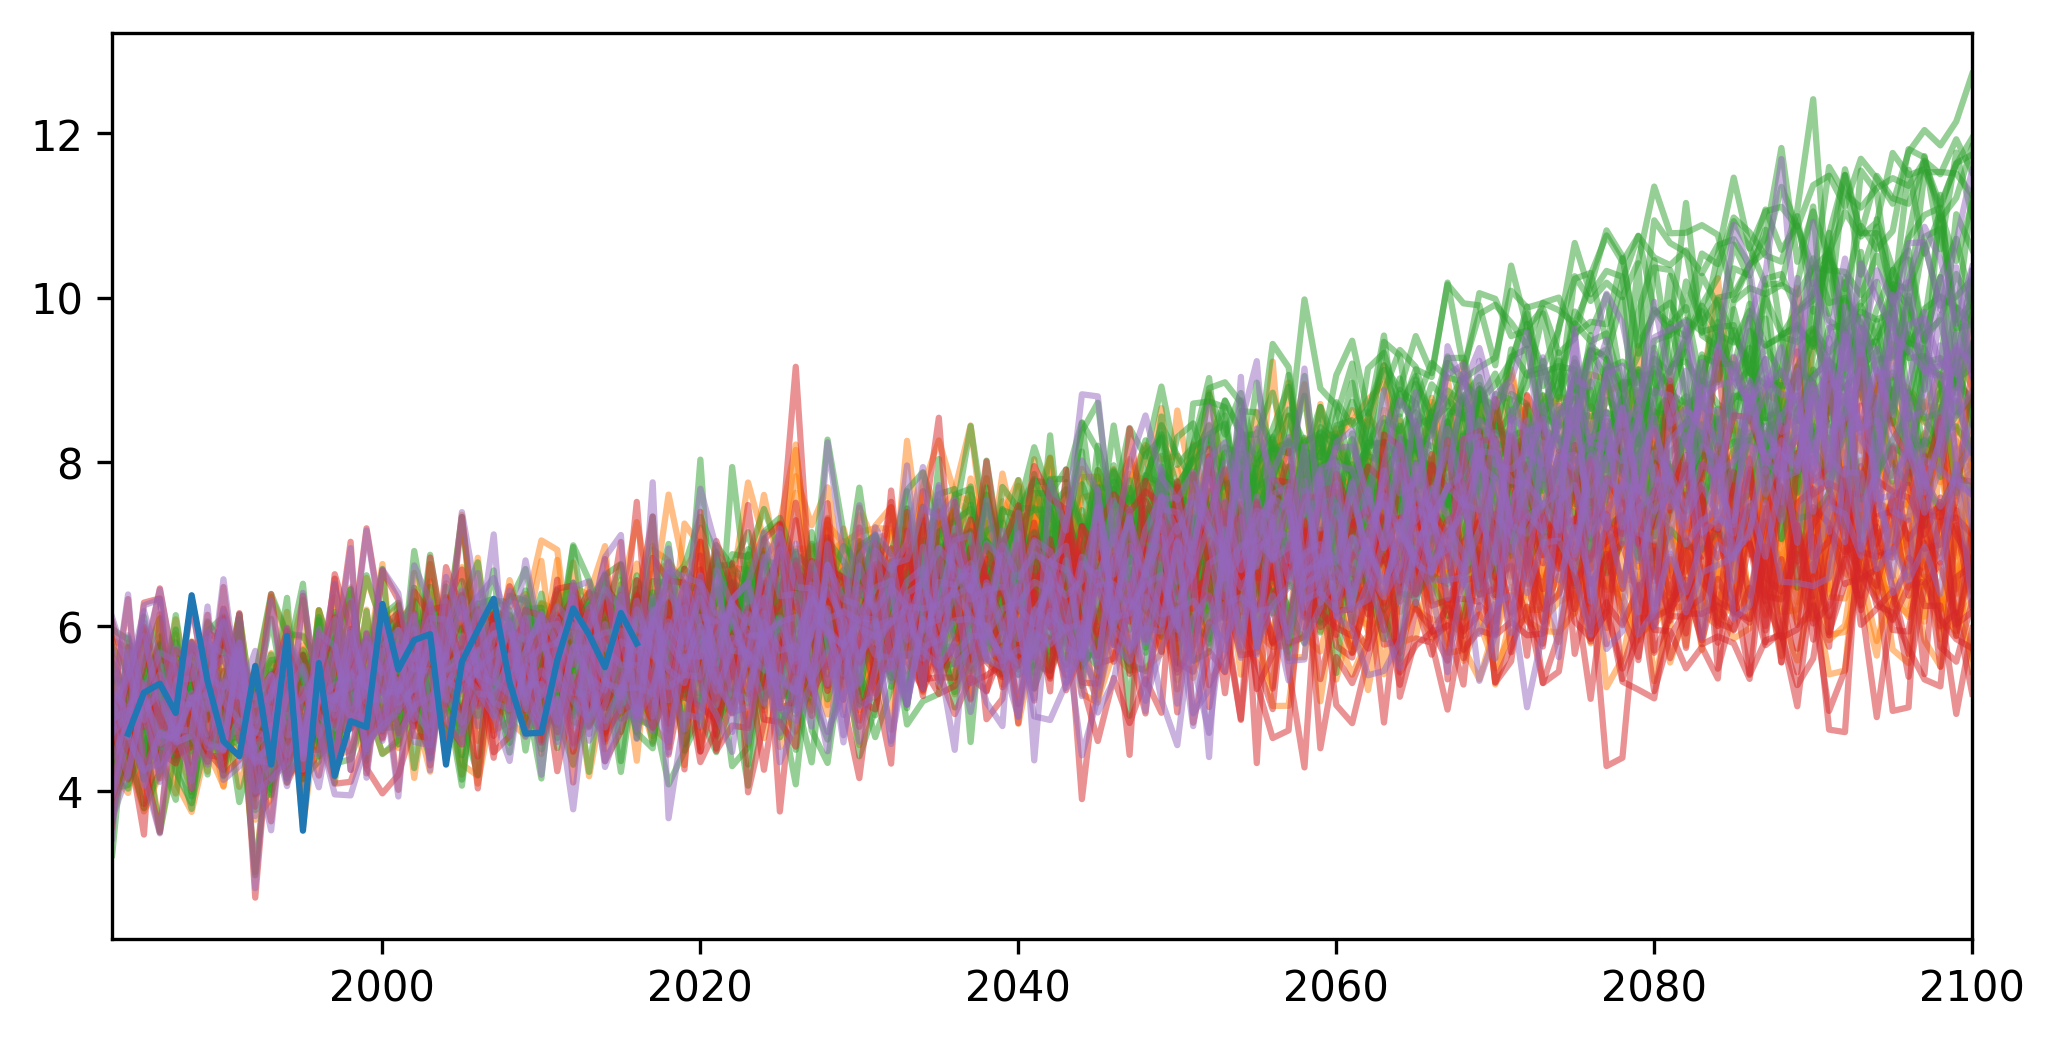

In [89]:
fig=plt.figure(dpi=300, figsize=(8,4))
ax=plt.subplot(111)
T_BA_45.plot(c="C1", alpha = 0.5, legend=False, ax=ax)
T_BA_85.plot(c="C2", alpha = 0.5, legend=False, ax=ax)
all_BA_45.plot(c="C3", alpha= 0.5, legend=False, ax=ax)
all_BA_85.plot(c="C4", alpha= 0.5, legend=False, ax=ax)
ax.plot(mtbs_years, mtbs_BA, c="C0")
plt.show()

In [68]:
div = "Temperate Steppe Regime Mountains"
row1, f1 = burn_area_projections(div, lasso_temperature_BA_45[div], lasso_temperature_BA_85[div], 
                                 lasso_all_BA_45[div], lasso_all_BA_85[div])

In [69]:
div = "Marine Regime Mountains"
row2, f2 = burn_area_projections(div, lasso_temperature_BA_45[div], lasso_temperature_BA_85[div], 
                                 lasso_all_BA_45[div], lasso_all_BA_85[div])

In [70]:
div = "Mediterranean Regime Mountains"
row3, f3 = burn_area_projections(div, lasso_temperature_BA_45[div], lasso_temperature_BA_85[div], 
                                 lasso_all_BA_45[div], lasso_all_BA_85[div])

In [71]:
# Combine desired outputs with information in this thread
# https://stackoverflow.com/questions/30227466/combine-several-images-horizontally-with-python

# for a vertical stacking it is simple: use vstack
import PIL
list_im = [f1, f2, f3]
imgs    = [ PIL.Image.open(i) for i in list_im ]

# pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )

imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( os.path.join(dataDir, 'burn_area_projections_mountains.png') )

/Users/sbrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/Users/sbrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


In [49]:
dataDir

'../Data/Fire_Analysis/CARTHAGE_MUST_BURN_50_transofromation_log10'

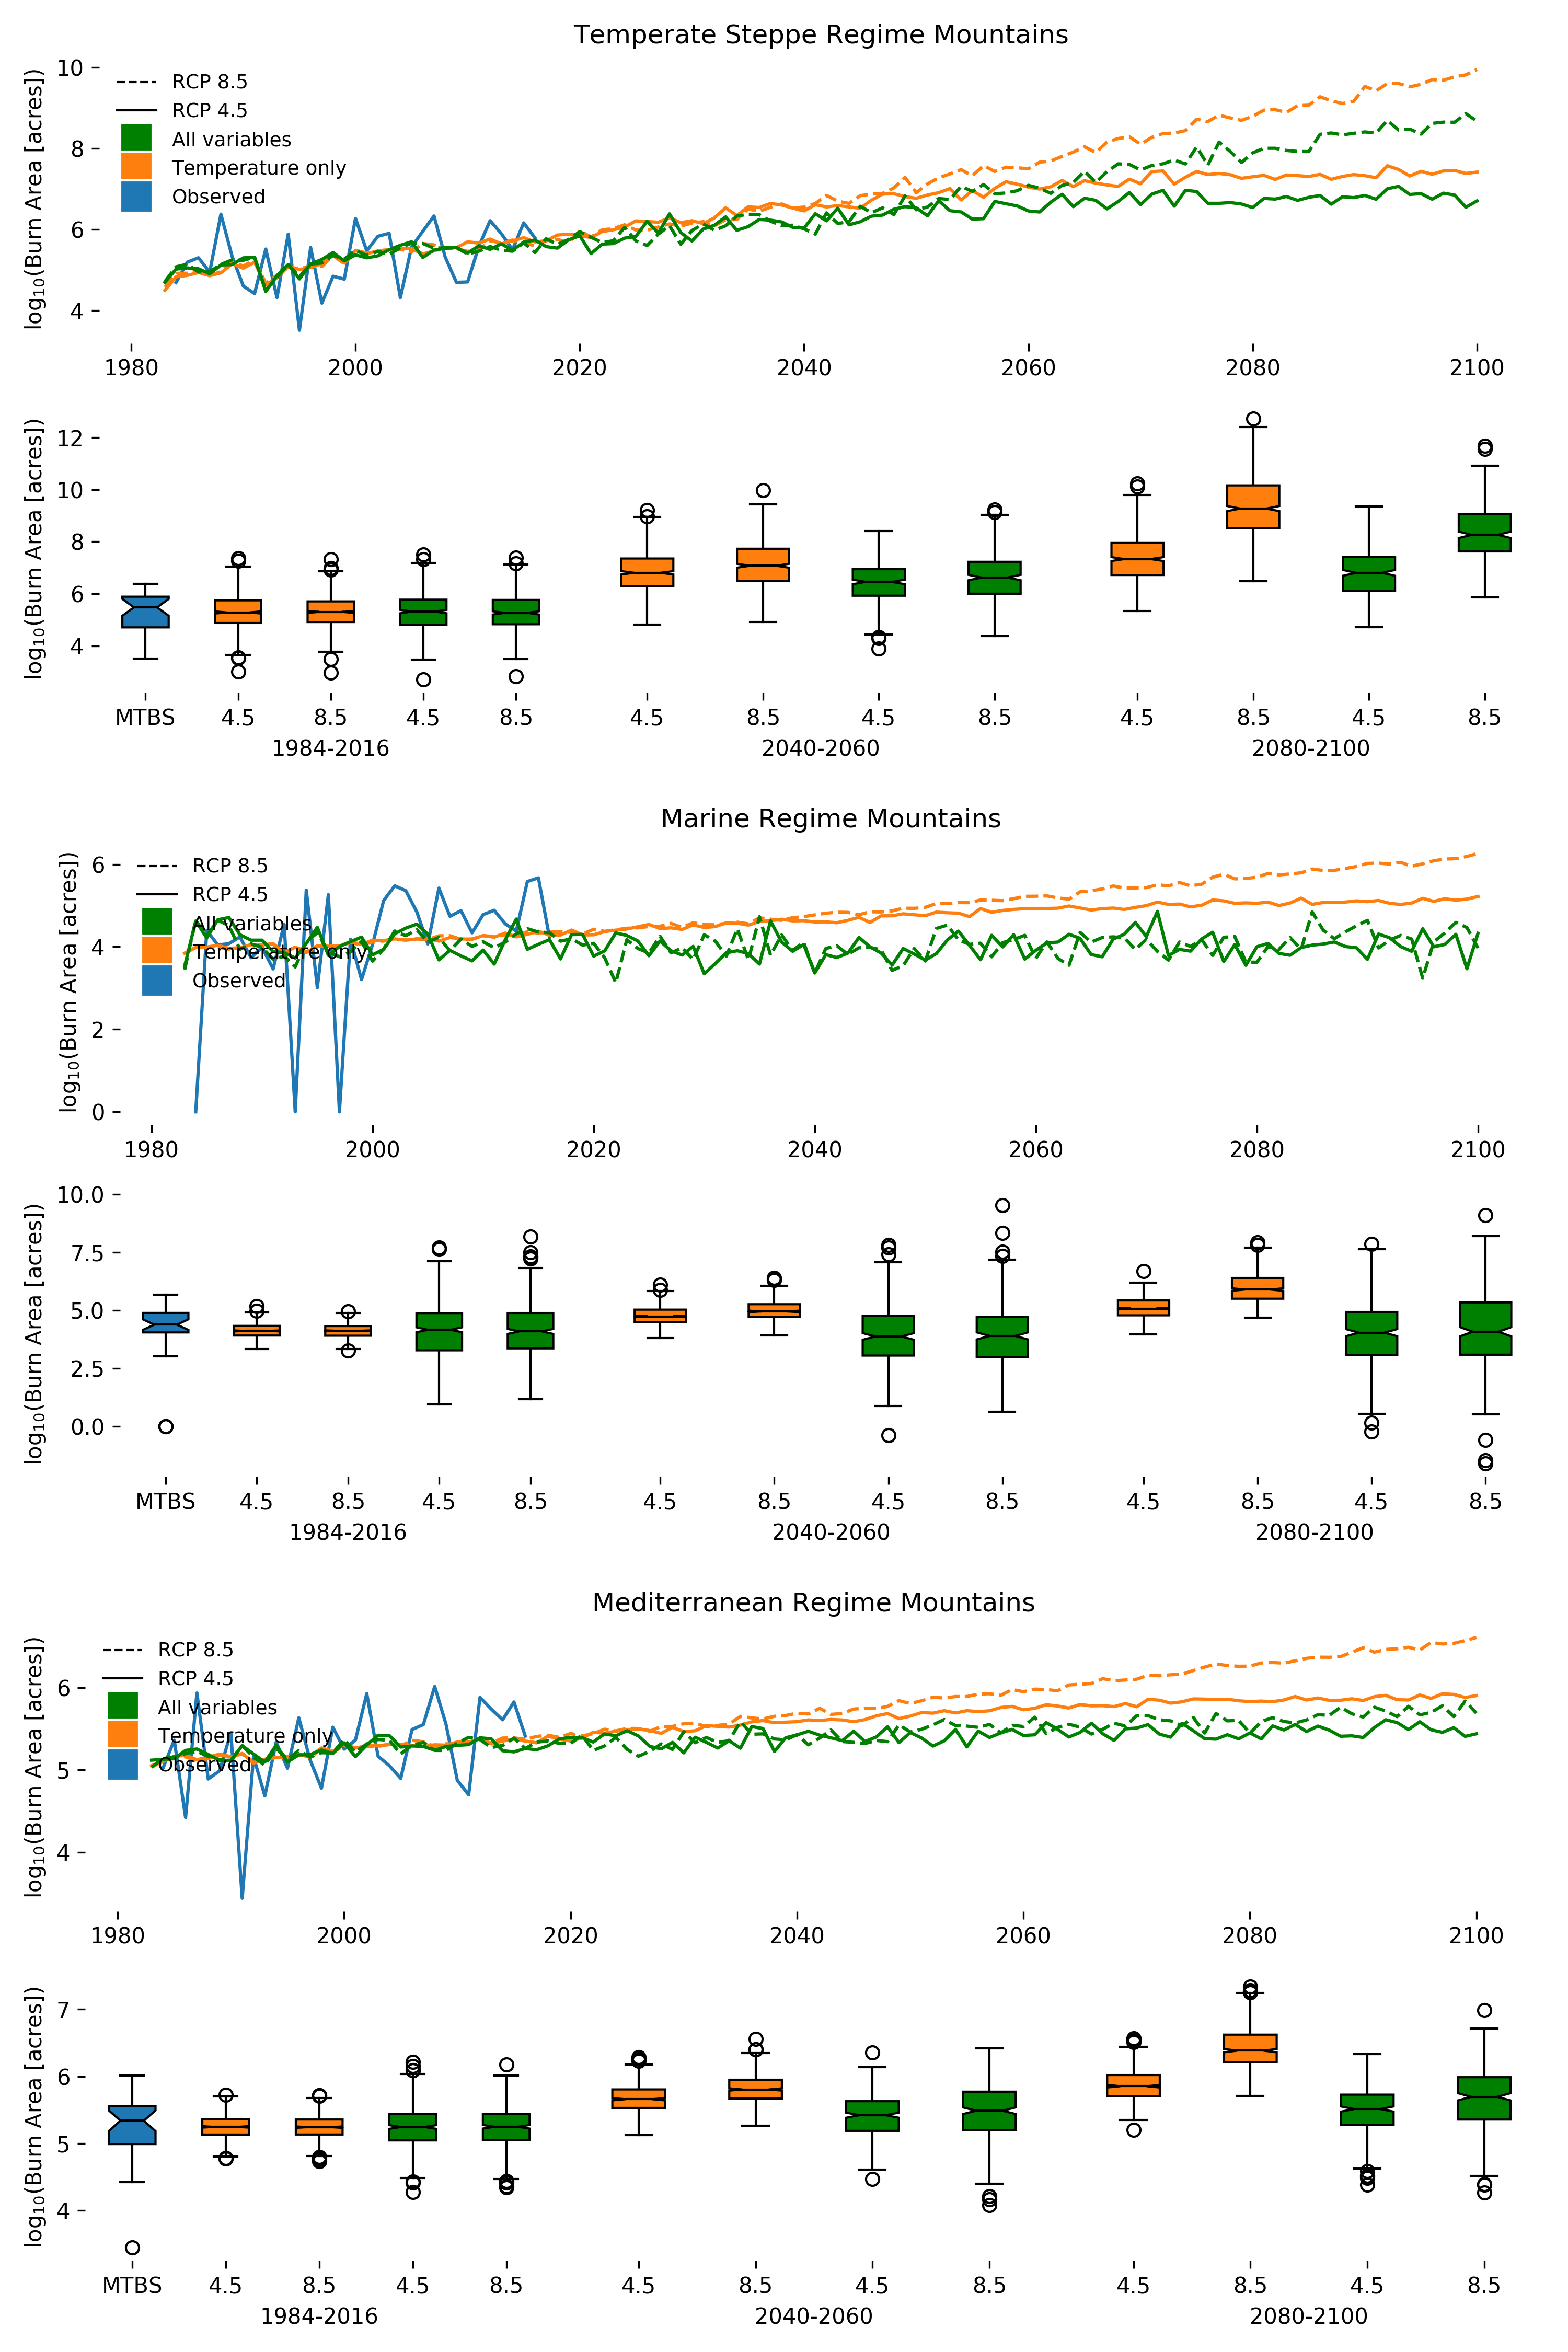

In [66]:
from IPython.display import Image
Image(os.path.join(dataDir, 'burn_area_projections_mountains.png'))

Temperate Steppe Regime Mountains (top), Marine Regime Mountains (middle), and Mediterranean Regime Mountains (bottom) burn area projections using lasso regression trained with plant- and atmospheric-centric predictors for RCPs 4.5 and 8.5. The line plots show the ensemble mean of individual CMIP5 model burn area projections for a given regression type and RCP. Right of each time series there are arrows that show the spread in estimated burn area for the year 2100 across RCPs and regression types. Below the time series, box plots that show the distribution of individual summer burn area estimates from all available CMIP5 models for the years indicated on the horizontal axis label. These distributions are separated by regression type (color) as well as RCP ( horizontal axis tick labels). 

In [52]:
div = 'Temperate Desert Division'
_, _ = burn_area_projections(div, lasso_temperature_BA_45[div], lasso_temperature_BA_85[div], 
                                 lasso_all_BA_45[div], lasso_all_BA_85[div])

In [55]:
 for div in lasso_temperature_BA_45.keys() :
    try :
        _, _ = burn_area_projections(div, lasso_temperature_BA_45[div], lasso_temperature_BA_85[div], 
                                 lasso_all_BA_45[div], lasso_all_BA_85[div])
        
    except  :
        
        print("something went wrong with  " + div)

something went wrong with  Tropical/Subtropical Regime Mountains


### Start analysis related to possible plant "buffering"
- Do CMIP5 models representation of plants response to CO2 offer any evidence that plant physiology caused changes to variables may “buffer” increased burn area? 
- Make a swarmplot of the sign of delta_phys, put the sign of the change from low CO2 to high CO2 in context of the historical regression coeficient signs. 

In [236]:
from glob import glob # to get *physrun_deltas.nc files 
from netCDF4 import Dataset

In [237]:
delta_phys_dir = os.path.join("..","Data","rad_phys", "rad_phys_split_common_grid/")

In [238]:
delta_files = glob(delta_phys_dir+"*physrun_deltas.nc")

In [239]:
# Clean no datadir version
delta_name = []
for f in delta_files : 
    delta_name.append( f.replace(delta_phys_dir, "").replace(".nc","") )
delta_name = np.array(delta_name)
delta_name[:5]

array(['evspsbl_bcc-csm1-1_physrun_deltas',
       'evspsbl_CanESM2_physrun_deltas',
       'evspsbl_CESM1-BGC_physrun_deltas',
       'evspsbl_GFDL-ESM2M_physrun_deltas',
       'evspsbl_HadGEM2-ES_physrun_deltas'], dtype='<U35')

In [258]:
def get_season_delta(f_long, season) :
    """
    Parameters
    ----------
    f_long : str, file name, full path on disk 
    season : str, the season of the delta to load 
    
    return
    ------
    DELTA : global delta grid
    START_STD : global standard deviation associated with start period
                that was used to calculate delta 
    """
    
    # Connect the nc data for this file 
    nc = Dataset(f_long, "r")
    
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    #delta_winter = nc.variables["delta_winter"][:].data
    #delta_spring = nc.variables["delta_spring"][:].data
    #delta_summer = nc.variables["delta_summer"][:].data
    DELTA = nc.variables["delta_"+season][:].data
    
    START_STD = nc.variables[season+"_start_std"][:].data
    
    nc.close()
    
    return DELTA, START_STD, lon, lat 

In [259]:
mt_divisions = ["Temperate Steppe Regime Mountains", "Marine Regime Mountains", "Mediterranean Regime Mountains"]
mask_dict = {}

In [260]:
# Load needed western US ecoregions masks 
mask_file = os.path.join("..","Data","LandCover", "bailys_division_masks_common_grid.nc")
nc = Dataset(mask_file,"r")
print(nc.variables.keys())
mask_dict["Temperate Steppe Regime Mountains"] = nc.variables["Temperate Steppe Regime Mountains"][:]
mask_dict["Marine Regime Mountains"] = nc.variables["Marine Regime Mountains"][:]
mask_dict["Mediterranean Regime Mountains"] = nc.variables["Mediterranean Regime Mountains"][:]
mask_lat = nc.variables["lat"][:]
mask_lon = nc.variables["lon"][:]
nc.close()

odict_keys(['lon', 'lon_bnds', 'lat', 'lat_bnds', 'Hot Continental Division', 'Hot Continental Regime Mountains', 'Marine Division', 'Marine Regime Mountains', 'Mediterranean Division', 'Mediterranean Regime Mountains', 'Prairie Division', 'Rainforest Regime Mountains', 'Savanna Division', 'Savanna Regime Mountains', 'Subarctic Division', 'Subarctic Regime Mountains', 'Subtropical Division', 'Subtropical Regime Mountains', 'Temperate Desert Division', 'Temperate Desert Regime Mountains', 'Temperate Steppe Division', 'Temperate Steppe Regime Mountains', 'Tropical Subtropical Desert Division', 'Tropical Subtropical Regime Mountains', 'Tropical Subtropical Steppe Division', 'Tundra Division', 'Tundra Regime Mountains', 'Warm Continental Division', 'Warm Continental Regime Mountains', 'western_US'])


In [261]:
seasons_list = ["winter", "spring", "summer"]

In [262]:
# TODO: the deltas being calcuated next should really be calculated in terms of ERA sigma? 
# TODO: but these data are not scaled or slope corrected, so that is harder to interpret. 

In [263]:
delta_means = []
variables = []
features = []
seasons = []
models = []
divisions = []

for f,f_long in zip(delta_name, delta_files) : 

    # Get variavle model info
    variable = f.split("_")[0]
    model    = f.split("_")[1]
    
    # rename soil when it comes up to match my
    # naming scheme
    if variable == "mrs3m" :
        variable = 'mrlsl.integrated'
    
    # We do not want to look at "hfls"
    if (variable != "hfls") : 
    
        # For each file there are 3 seasons
        for s in seasons_list : 

            # Get the global delta values 
            delta, st_dev, lon, lat = get_season_delta(f_long, s)

            # And 3 divisions
            for div in mt_divisions : 

                # zero where we WANT to mask 
                spatial_mask = mask_dict[div]==0
                nan_mask = np.isnan(delta)

                delta_masked = np.ma.masked_where(spatial_mask | nan_mask, delta)
                st_dev_masked = np.ma.masked_where(spatial_mask | nan_mask, st_dev)
                # Spatial mean in sigma units 
                delta_sigma_units = np.ma.mean(delta_masked)/ np.ma.mean(st_dev_masked)

                # TODO: print the very specific condition ?
                # Store all the unique combination of values at this nested level 
                delta_means.append( delta_sigma_units )
                variables.append( variable )
                seasons.append(s)
                features.append( variable + "_" + s) # matches other analysis! 
                models.append(model)
                divisions.append(div)

In [264]:
df_phys_deltas = pd.DataFrame({"delta_means":delta_means,"variables":variables,"features":features,"seasons":seasons,"models":models,"divisions":divisions})

In [265]:
print(df_phys_deltas.shape)

(432, 6)


In [266]:
df_phys_deltas["phys_sign"] = np.sign(df_phys_deltas.loc[:, "delta_means"])
df_phys_deltas.head()

delta_means variables        features seasons      models  \
0    -0.094436   evspsbl  evspsbl_winter  winter  bcc-csm1-1   
1    -0.018640   evspsbl  evspsbl_winter  winter  bcc-csm1-1   
2     0.001947   evspsbl  evspsbl_winter  winter  bcc-csm1-1   
3    -0.067527   evspsbl  evspsbl_spring  spring  bcc-csm1-1   
4    -0.077480   evspsbl  evspsbl_spring  spring  bcc-csm1-1   

                           divisions  phys_sign  
0  Temperate Steppe Regime Mountains       -1.0  
1            Marine Regime Mountains       -1.0  
2     Mediterranean Regime Mountains        1.0  
3  Temperate Steppe Regime Mountains       -1.0  
4            Marine Regime Mountains       -1.0

In [267]:
df_phys_deltas['regression_coef'] = np.nan
df_phys_deltas['regression_coef_sign'] = np.nan

In [268]:
# Figure out what the sign implies. Where the delta_mean has the
# same sign as the regression coef plants tend to change in a way that increases
# burn area, when oppopsite, they buffer. 

for i in range(df_phys_deltas.shape[0]) :
    
    # Get the division name and feature name in order to 
    # get the coeficient out of the coef dataframe 
    div = df_phys_deltas.loc[i, "divisions"]
    feature = df_phys_deltas.loc[i, "features"]
    
    # Get corosponding coef, if it exists. 
    if pd.Series(feature).isin(lasso_all_coefs.columns)[0] : 
        coef = lasso_all_coefs.loc[div, feature]
        df_phys_deltas.loc[i, 'regression_coef'] = coef
        df_phys_deltas.loc[i, 'regression_coef_sign' ] = np.sign(coef)

In [269]:
~ np.array([True, True, False])

array([False, False,  True])

In [270]:
df_phys_deltas = df_phys_deltas[ ~ np.isnan(df_phys_deltas.regression_coef) ]

In [278]:
df_phys_deltas["buffer"] = "no"
df_phys_deltas.loc[df_phys_deltas.phys_sign != df_phys_deltas.regression_coef_sign,"buffer"] = "yes"

In [279]:
# get rid of rows where the coef is 0
df_phys_deltas_selected = df_phys_deltas[df_phys_deltas.regression_coef_sign!=0.].copy()
print(df_phys_deltas.shape)
print(df_phys_deltas_selected.shape)

(414, 10)
(187, 10)


In [293]:
# Where coef * delta is positive, plants enhance burn area, where negative, they buffer. 
df_phys_deltas_selected["delta_buffer"] = df_phys_deltas_selected.delta_means * df_phys_deltas_selected.regression_coef_sign

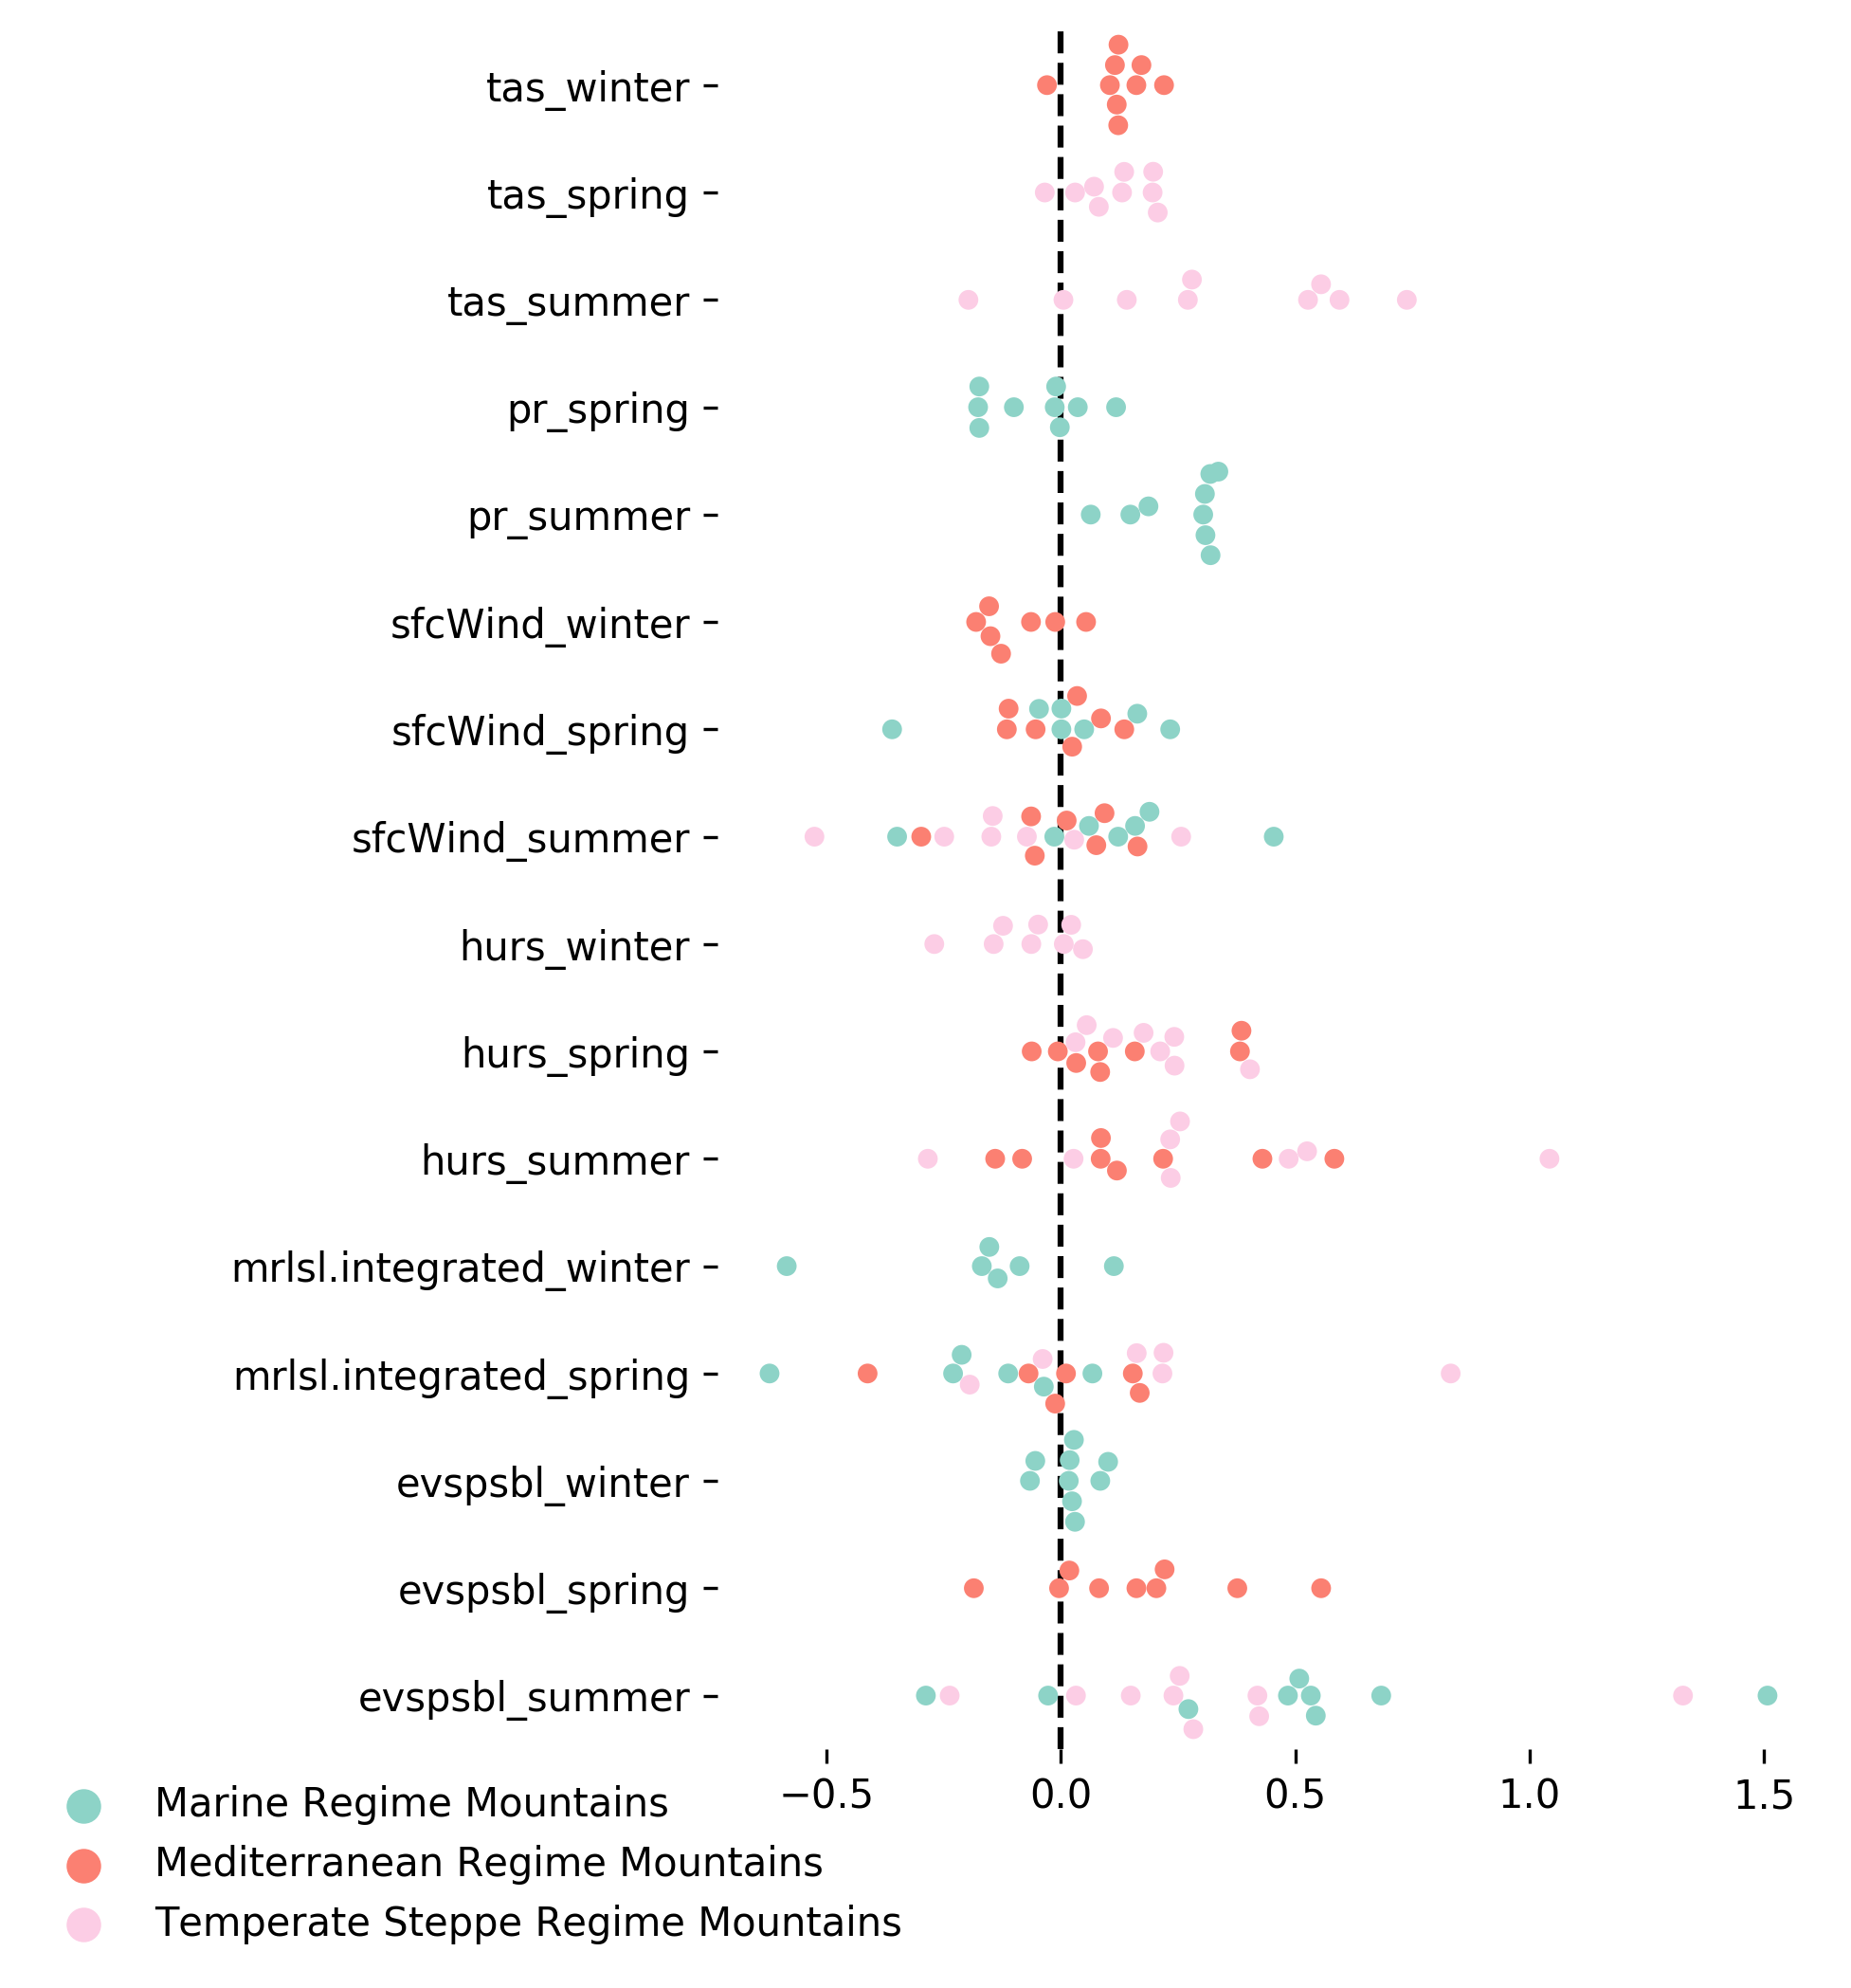

In [303]:
plt.figure(dpi=300, figsize=(5,8))
ax = sns.swarmplot(x="delta_buffer", y="features", hue="divisions", 
                   order=plot_order, palette=div_color_dict, # works when hue is division 
                   data=df_phys_deltas_selected)
plt.ylabel("")
plt.xlabel("")
ax.axvline(x=0, linestyle="--", color="k")
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

leg = ax.get_legend()
# [left, bottom, width, height]
leg.set_bbox_to_anchor((-0.1, 0.5, 0.3, -0.5))
leg.set_label(mt_divisions)
leg.set_title("")
leg.set_frame_on(False)

plt.show()